<a href="https://colab.research.google.com/github/Jorge-Esteban/Busines-Intelligence-and-Data-Mining-Project/blob/main/BI%26DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BI & DM PROJECT



This notebook presents a  project for the **Business Intelligence and Data Mining** module at the University of the West of England, Bristol.


This project implements a **Shopping Recommender System** using data mining and machine learning techniques. The work herein demonstrates our application of analytical and technical skills to address real-world business intelligence challenges.

# __Imports and Get Data__

Frist of all let's import the libraries and turn the csv files into data frames.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from surprise import SVD, KNNBasic, NMF, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

# Text Processing Libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

# Sentiment Analysis
from LeIA import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Jorge
[nltk_data]     Esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jorge
[nltk_data]     Esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
customer_data = pd.read_csv('olist_customers_dataset.csv')
order_data = pd.read_csv('olist_orders_dataset.csv')
order_item_data = pd.read_csv('olist_order_items_dataset.csv')
order_payments_data = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews_data = pd.read_csv('olist_order_reviews_dataset.csv', encoding='latin1')
seller_data = pd.read_csv('olist_sellers_dataset.csv')
product_data = pd.read_csv('olist_products_dataset.csv')
category_data = pd.read_csv('product_category_name_translation.csv')
geolocation_data = pd.read_csv('olist_geolocation_dataset.csv')

#Show heads of all dataframes
print(customer_data.head(), '\n')
print(order_data.head(), '\n')
print(order_item_data.head(), '\n')
print(order_payments_data.head(), '\n')
print(order_reviews_data.head(), '\n')
print(seller_data.head(), '\n')
print(product_data.head(), '\n')
print(category_data.head(), '\n')
print(geolocation_data.head(), '\n')

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP   

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53

# __Exploratory Data Analysis__ #

In this section we will analyse each part of the dataset separetely and looking for its data quality, any possible fixing getting our first dive into what he dataset offer us. First there will be an analysis on each part and then the cross information of all of them.

## __1. Customer dataset__

In [ ]:
customer_data.info()
customer_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000

Since zip codes doesn't measure anything we can assume them as objects instead of integer. This will make them easier to work with.

In [ ]:
customer_data['customer_zip_code_prefix'] = customer_data['customer_zip_code_prefix'].astype(object)

In [ ]:
customer_data.describe(include='all')

customer_id                customer_unique_id  \
count                              99441                             99441   
unique                             99441                             96096   
top     06b8999e2fba1a1fbc88172c00ba8bc7  8d50f5eadf50201ccdcedfb9e2ac8455   
freq                                   1                                17   

        customer_zip_code_prefix customer_city customer_state  
count                      99441         99441          99441  
unique                     14994          4119             27  
top                        22790     sao paulo             SP  
freq                         142         15540          41746

In [ ]:
#Look for missing values
customer_data.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

There is no missing values so that is great.

Moving on, let's do some useful plots to understand the data distribution and tendencies.

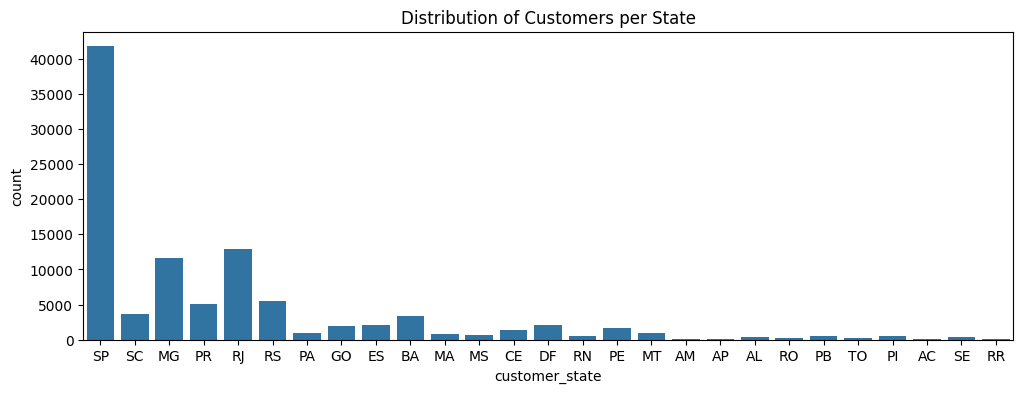

In [ ]:
#Plot the distribution of customer states
plt.figure(figsize=(12,4))
sns.countplot(x='customer_state', data=customer_data)
plt.title('Distribution of Customers per State')
plt.show()

As we can se most of the customers are located in the State of Sao Paulo

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\2156762852.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sns.countplot(x='customer_city', data=customer_data, order=pd.value_counts(customer_data['customer_city']).iloc[:10].index)


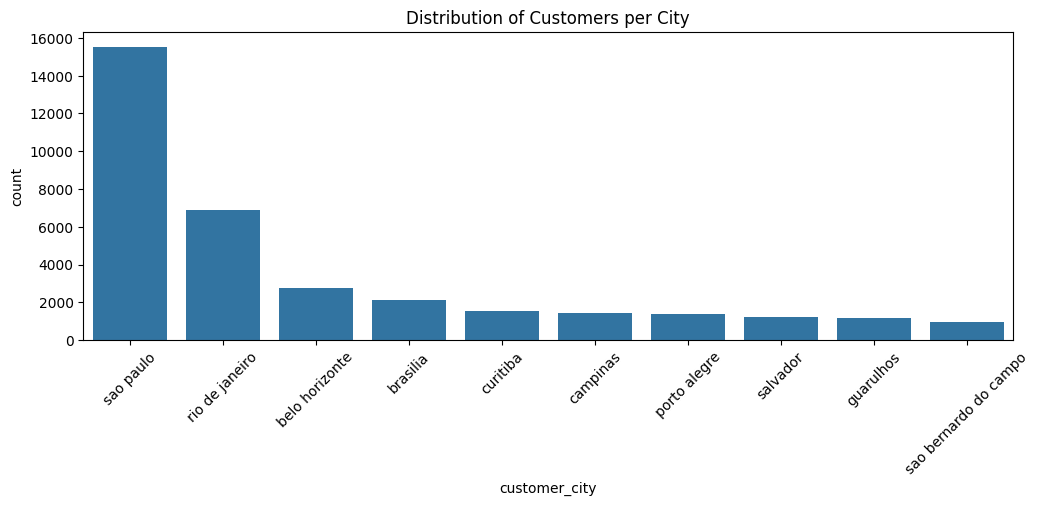

In [ ]:
#Plot the distribution of customer cities
plt.figure(figsize=(12,4))
sns.countplot(x='customer_city', data=customer_data, order=pd.value_counts(customer_data['customer_city']).iloc[:10].index)
plt.title('Distribution of Customers per City')
plt.xticks(rotation=45)
plt.show()

The city withe the most customers is Sao Paulo. We expected this as it is the same as the States plot.

<Figure size 1200x400 with 0 Axes>

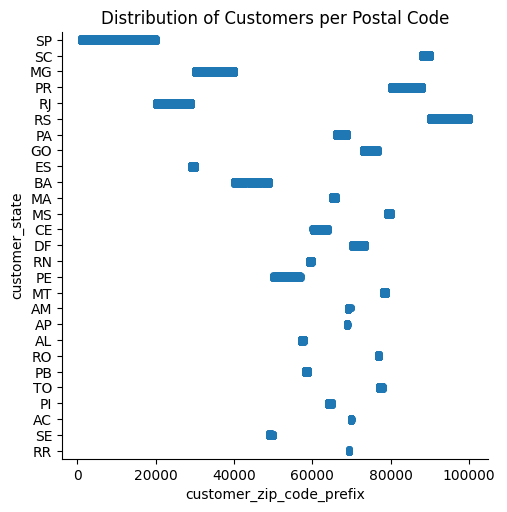

In [ ]:
# ScatPlot the distribution of customer postal codes
plt.figure(figsize=(12,4))
sns.catplot(x='customer_zip_code_prefix', y='customer_state', data=customer_data)
plt.title('Distribution of Customers per Postal Code')
plt.show()

With this scat plot we can see which state has more postal codes, which makes sense to be SP as it is the city with most customers.

## __2. Order dataset__

In [ ]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Is better to change all dates to date time.

In [ ]:
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data['order_approved_at'] = pd.to_datetime(order_data['order_approved_at'])
order_data['order_delivered_carrier_date'] = pd.to_datetime(order_data['order_delivered_carrier_date'])
order_data['order_delivered_customer_date'] = pd.to_datetime(order_data['order_delivered_customer_date'])
order_data['order_estimated_delivery_date'] = pd.to_datetime(order_data['order_estimated_delivery_date'])
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [ ]:
order_data.describe()

order_purchase_timestamp              order_approved_at  \
count                          99441                          99281   
mean   2017-12-31 08:43:12.776581120  2017-12-31 18:35:24.098800128   
min              2016-09-04 21:15:19            2016-09-15 12:16:38   
25%              2017-09-12 14:46:19            2017-09-12 23:24:16   
50%              2018-01-18 23:04:36            2018-01-19 11:36:13   
75%              2018-05-04 15:42:16            2018-05-04 20:35:10   
max              2018-10-17 17:30:18            2018-09-03 17:40:06   

        order_delivered_carrier_date  order_delivered_customer_date  \
count                          97658                          96476   
mean   2018-01-04 21:49:48.138278656  2018-01-14 12:09:19.035542272   
min              2016-10-08 10:34:01            2016-10-11 13:46:32   
25%    2017-09-15 22:28:50.249999872  2017-09-25 22:07:22.249999872   
50%              2018-01-24 16:10:58     2018-02-02 19:28:10.500000   
75%              2018-05-08 13:37:45  2018-05-15 22:48:52.249999872   
max              2018-09-11 19:48:28            2018-10-17 13:22:46   

       order_estimated_delivery_date  
count                          99441  
mean   2018-01-24 03:08:37.730111232  
min              2016-09-30 00:00:00  
25%              2017-10-03 00:00:00  
50%              2018-02-15 00:00:00  
75%              2018-05-25 00:00:00  
max              2018-11-12 00:00:00

In [ ]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Since there is some missing data, lets check how much with percentage so it's easier to understand.

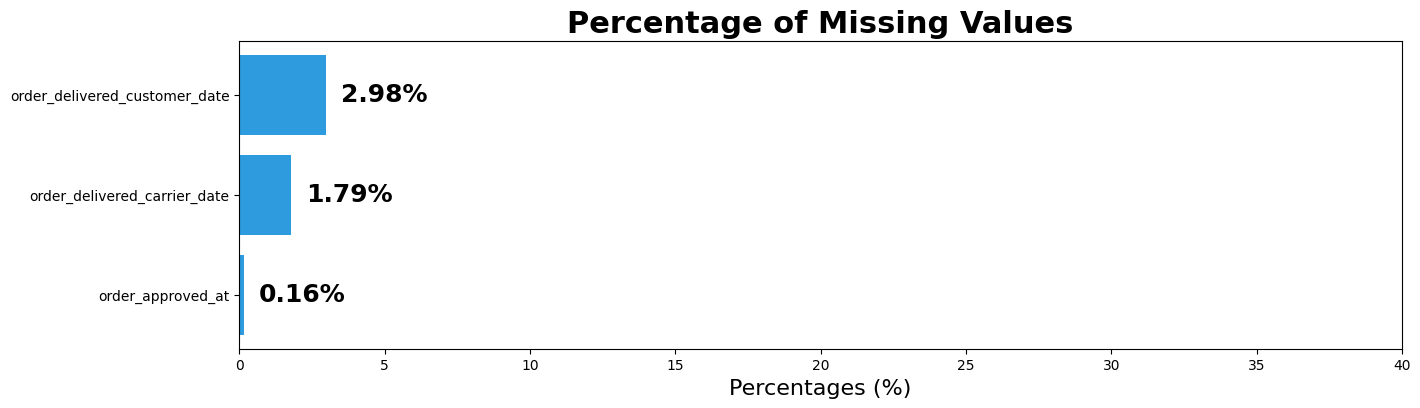

In [ ]:
# Calculating the percentage of missing values for each column
missing_data = order_data.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / order_data.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#2e9bde')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

Here we find many null values in some columns. Let's check why is that and if it's correct or not.

The columns with missing values reffer to date of the delivery process. So it may have something to do with the status of each order. Let's check withy some plots.


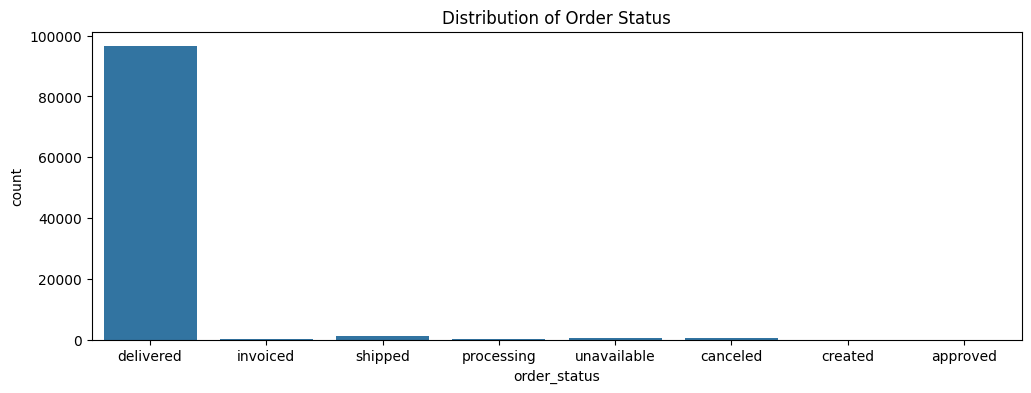

In [ ]:
#Plot order status distribution, include null values
plt.figure(figsize=(12,4))
sns.countplot(x='order_status', data=order_data)
plt.title('Distribution of Order Status')
plt.show()

In [ ]:
order_data[order_data['order_approved_at'].isnull()]

order_id                       customer_id  \
1130   00b1cb0320190ca0daa2c88b35206009  3532ba38a3fd242259a514ac2b6ae6b6   
1801   ed3efbd3a87bea76c2812c66a0b32219  191984a8ba4cbb2145acb4fe35b69664   
1868   df8282afe61008dc26c6c31011474d02  aa797b187b5466bc6925aaaa4bb3bed1   
2029   8d4c637f1accf7a88a4555f02741e606  b1dd715db389a2077f43174e7a675d07   
2161   7a9d4c7f9b068337875b95465330f2fc  7f71ae48074c0cfec9195f88fcbfac55   
...                                 ...                               ...   
97696  5a00b4d35edffc56b825c3646a99ba9d  6a3bdf004ca96338fb5fad1b8d93c2e6   
98415  227c804e2a44760671a6a5697ea549e4  62e7477e75e542243ee62a0ba73f410f   
98909  e49e7ce1471b4693482d40c2bd3ad196  e4e7ab3f449aeb401f0216f86c2104db   
99283  3a3cddda5a7c27851bd96c3313412840  0b0d6095c5555fe083844281f6b093bb   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   

      order_status order_purchase_timestamp order_approved_at  \
1130      canceled      2018-08-28 15:26:39               NaT   
1801      canceled      2018-09-20 13:54:16               NaT   
1868      canceled      2017-03-04 12:14:30               NaT   
2029      canceled      2018-08-29 16:27:49               NaT   
2161      canceled      2017-05-01 16:12:39               NaT   
...            ...                      ...               ...   
97696     canceled      2017-07-02 15:38:46               NaT   
98415     canceled      2017-09-28 15:02:56               NaT   
98909     canceled      2018-08-07 11:16:28               NaT   
99283     canceled      2018-08-31 16:13:44               NaT   
99347     canceled      2018-09-06 18:45:47               NaT   

      order_delivered_carrier_date order_delivered_customer_date  \
1130                           NaT                           NaT   
1801                           NaT                           NaT   
1868                           NaT                           NaT   
2029                           NaT                           NaT   
2161                           NaT                           NaT   
...                            ...                           ...   
97696                          NaT                           NaT   
98415                          NaT                           NaT   
98909                          NaT                           NaT   
99283                          NaT                           NaT   
99347                          NaT                           NaT   

      order_estimated_delivery_date  
1130                     2018-09-12  
1801                     2018-10-17  
1868                     2017-04-10  
2029                     2018-09-13  
2161                     2017-05-30  
...                             ...  
97696                    2017-07-25  
98415                    2017-10-16  
98909                    2018-08-10  
99283                    2018-10-01  
99347                    2018-09-27  

[160 rows x 8 columns]

We can se how every time theres been a cancel the rest of columns regarding the times of the delivery are null. Which makes sense. Still, since there is more missing date in 'order_delivered_carrier_date' and 'order_delivered_customer_date'

In [ ]:
#Show the null values of order_delivered_carrier_date without the null values of order_delivered_customer_date
order_data[order_data['order_delivered_carrier_date'].isnull()].head()

order_id                       customer_id  \
6    136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
103  0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128  15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
266  8e24261a7e58791d10cb1bf9da94df5c  64a254d30eed42cd0e6c36dddb88adf0   
324  d3c8851a6651eeff2f73b0e011ac45d0  957f8e082185574de25992dc659ebbc0   

    order_status order_purchase_timestamp   order_approved_at  \
6       invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
103     invoiced      2018-08-03 17:44:42 2018-08-07 06:15:14   
128   processing      2017-09-03 14:22:03 2017-09-03 14:30:09   
266  unavailable      2017-11-16 15:09:28 2017-11-16 15:26:57   
324   processing      2016-10-05 22:44:13 2016-10-06 15:51:05   

    order_delivered_carrier_date order_delivered_customer_date  \
6                            NaT                           NaT   
103                          NaT                           NaT   
128                          NaT                           NaT   
266                          NaT                           NaT   
324                          NaT                           NaT   

    order_estimated_delivery_date  
6                      2017-05-09  
103                    2018-08-21  
128                    2017-10-03  
266                    2017-12-05  
324                    2016-12-09

Let's se the frequency of each status

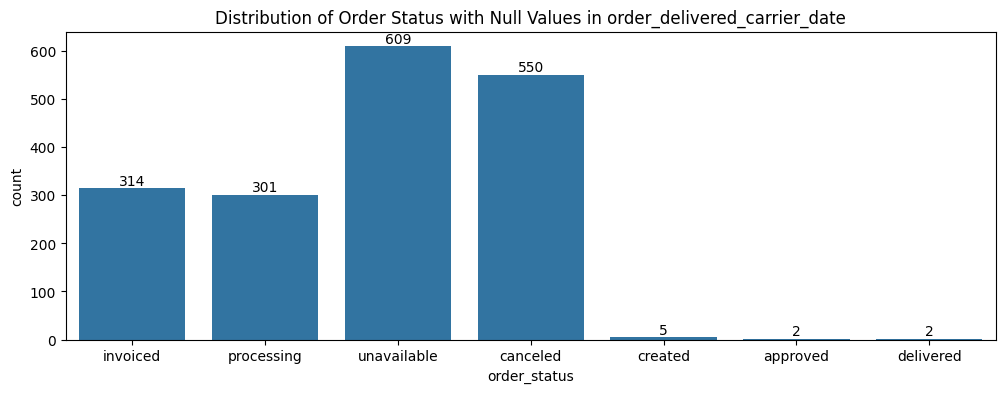

In [ ]:
#Plot the frequency of the diferent status based on the null values of order_delivered_carrier_date & the count in each bar
plt.figure(figsize=(12, 4))
ax = sns.countplot(x='order_status', data=order_data[order_data['order_delivered_carrier_date'].isnull()])
ax.bar_label(ax.containers[0])
plt.title('Distribution of Order Status with Null Values in order_delivered_carrier_date')
plt.show()

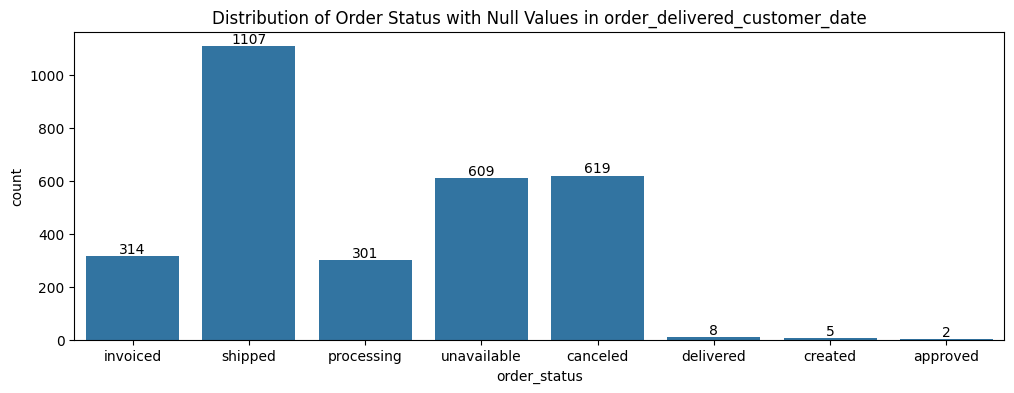

In [ ]:
#Plot the frequency of the diferent status based on the null values of order_delivered_customer_date & the count in each bar
plt.figure(figsize=(12, 4))
ax = sns.countplot(x='order_status', data=order_data[order_data['order_delivered_customer_date'].isnull()])
ax.bar_label(ax.containers[0])
plt.title('Distribution of Order Status with Null Values in order_delivered_customer_date')
plt.show()

What we can check with these Null values is how the process is going an where the packaege of the order is. So we can use this information in the future for various purposes.

No we can look for different plots that give as more usefull information.

With the next plot we can se a __distribution of when the purchases have been made.__

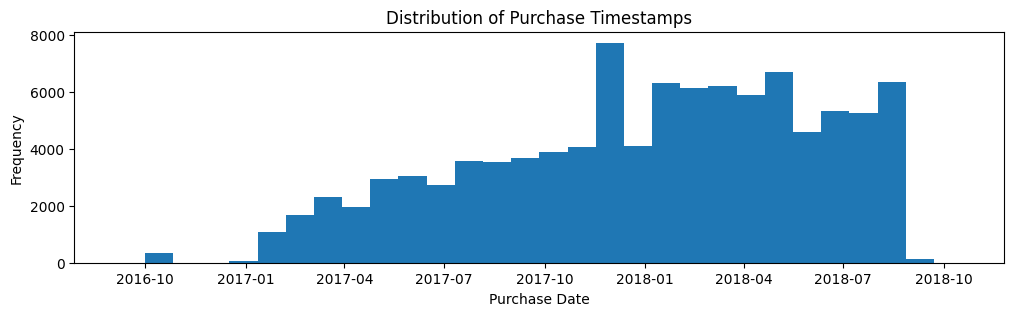

In [ ]:
plt.figure(figsize=(12, 3))
order_data['order_purchase_timestamp'].hist(bins=30)
plt.title('Distribution of Purchase Timestamps')
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

This next plot shows us the amount of products sold by day. This can be very helpful to analyse campaigns in specific time frames and special days and seasons such as Christmas or Black Friday.

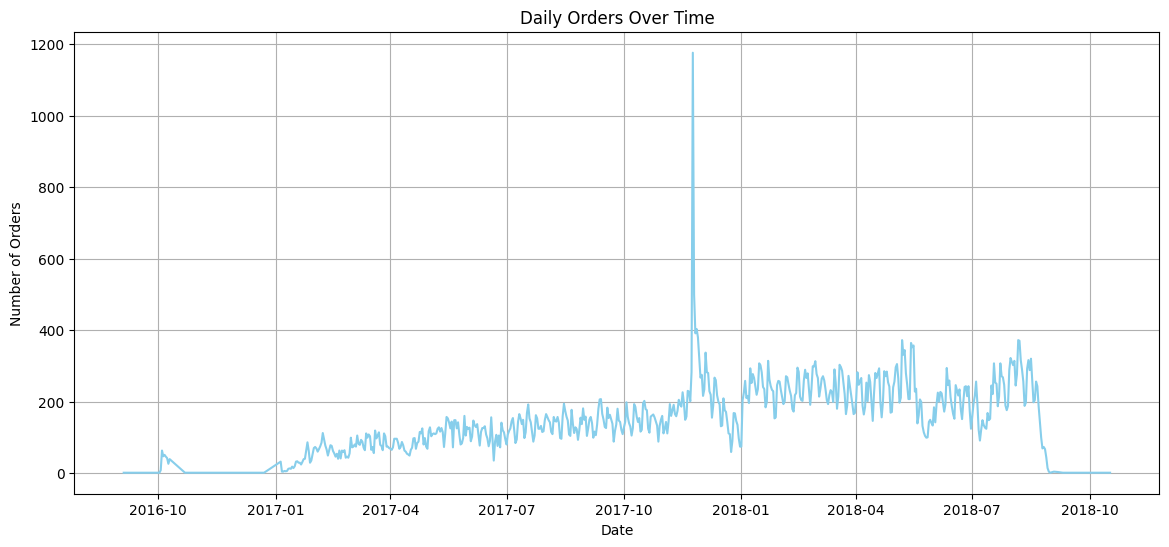

In [ ]:
# Making sure date time format
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])

# Group by date
daily_orders = order_data.groupby(order_data['order_purchase_timestamp'].dt.date).size()

# Plot time series
plt.figure(figsize=(14, 6))
daily_orders.plot(color='skyblue')
plt.title('Daily Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

We can also check how the delivery times have been. To measure if there is any incidence.

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\2823661402.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(order_data['delivery_time'].dropna(), bins=100, palette='crest', kde=True)


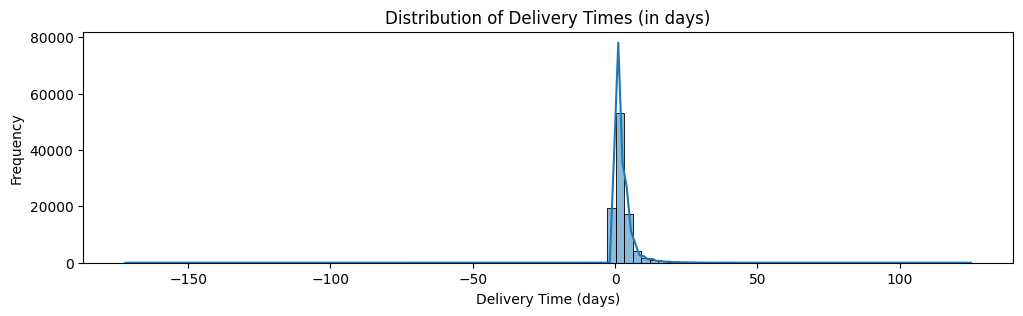

In [ ]:
# Time diference calculation
order_data['delivery_time'] = order_data['order_delivered_carrier_date'] - order_data['order_purchase_timestamp']
order_data['delivery_time'] = order_data['delivery_time'].dt.days

# Plot the distribution of delivery times
plt.figure(figsize=(12, 3))
sns.histplot(order_data['delivery_time'].dropna(), bins=100, palette='crest', kde=True)
plt.title('Distribution of Delivery Times (in days)')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Frequency')
plt.show()


Another intersting plot is the number of orders by day of the week.

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\3147015380.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='purchase_day_of_week', data=order_data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='crest')


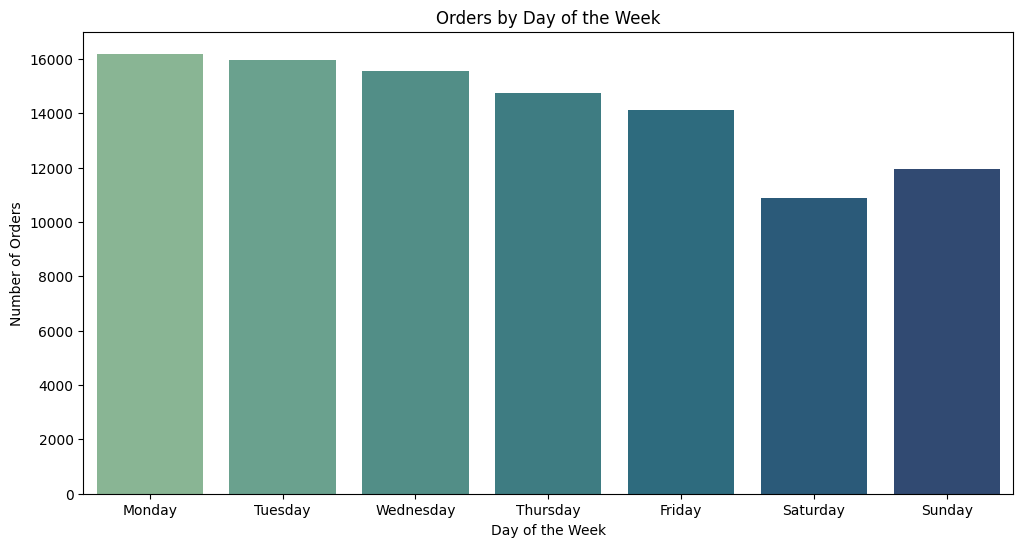

In [ ]:
# Obtener el día de la semana
order_data['purchase_day_of_week'] = order_data['order_purchase_timestamp'].dt.day_name()

# Conteo por día de la semana
plt.figure(figsize=(12, 6))
sns.countplot(x='purchase_day_of_week', data=order_data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='crest')
plt.title('Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

We can see how __most of the sales are in Mondays__ and they decrease during the week until sunday were the get back up a bit.

If we combine this with last plot with times of the day we can get a heatmap where it's posible to check at what times of the day there is more sales.

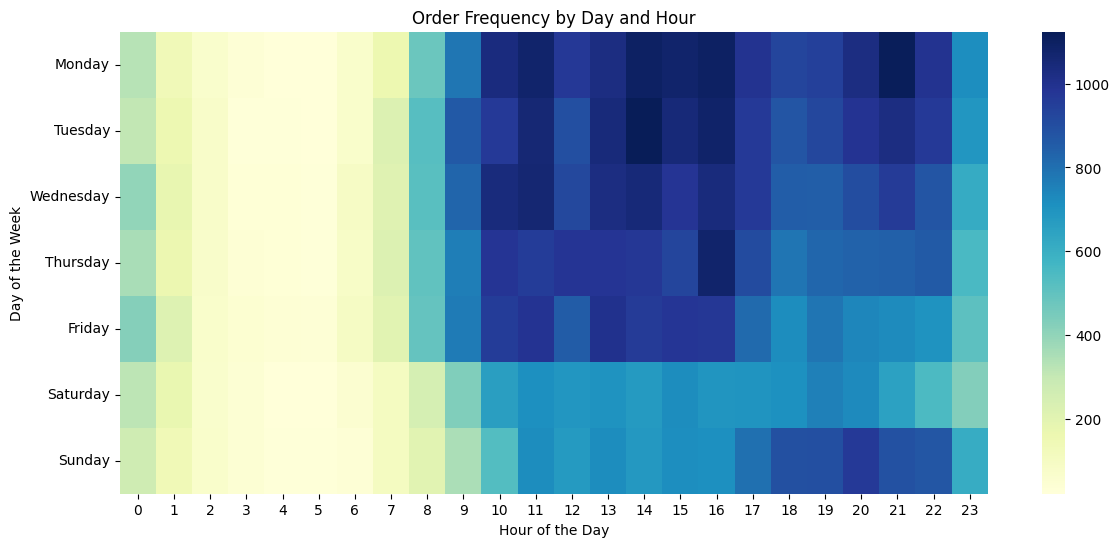

In [ ]:
# Obtain the hour of the day
order_data['purchase_hour'] = order_data['order_purchase_timestamp'].dt.hour

# Count by hour of the day
heatmap_data = order_data.pivot_table(index='purchase_day_of_week', columns='purchase_hour', aggfunc='size', fill_value=0)

# Reorder days of the week
heatmap_data = heatmap_data.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Order Frequency by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

In this last plot we can see how __customers prefer buying in the morning__ during the week days and then in the weekend is more distributed along the day with a peak in the sunday evening.

This plots are very intersting because we can cross them with customer information as wel as with items and product infomration which can be key for desinging campaigns for specific clients at specifc seasons, monhs, days and times.

## __3. Reviews dataset__

In [ ]:
order_reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41743 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [ ]:
order_reviews_data.describe(include='all')

review_id                          order_id  \
count                             100000                            100000   
unique                             99173                             99441   
top     2172867fd5b1a55f98fe4608e1547b4b  03c939fd7fd3b38f8485a0f95798f1f6   
freq                                   3                                 3   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

         review_score review_comment_title review_comment_message  \
count   100000.000000                11715                  41743   
unique            NaN                 4588                  36046   
top               NaN            Recomendo                   Good   
freq              NaN                  426                    375   
mean         4.070890                  NaN                    NaN   
std          1.359663                  NaN                    NaN   
min          1.000000                  NaN                    NaN   
25%          4.000000                  NaN                    NaN   
50%          5.000000                  NaN                    NaN   
75%          5.000000                  NaN                    NaN   
max          5.000000                  NaN                    NaN   

       review_creation_date review_answer_timestamp  
count                100000                  100000  
unique                  637                   89500  
top        19/12/2017 00:00        12/08/2017 14:35  
freq                    466                       6  
mean                    NaN                     NaN  
std                     NaN                     NaN  
min                     NaN                     NaN  
25%                     NaN                     NaN  
50%                     NaN                     NaN  
75%                     NaN                     NaN  
max                     NaN                     NaN

In [ ]:
order_reviews_data.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58257
review_creation_date           0
review_answer_timestamp        0
dtype: int64

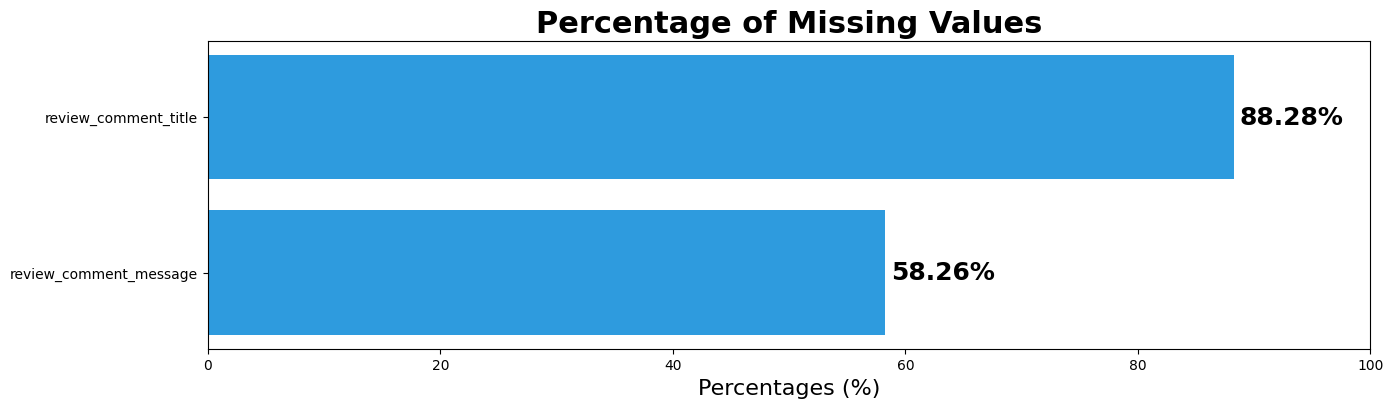

In [ ]:
# Calculating the percentage of missing values for each column
missing_data = order_reviews_data.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / order_reviews_data.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#2e9bde')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 100])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

Next plot shows the most common reviews. It's far from a proper sentiment analysis but can give us an idea about how the products are percieved.

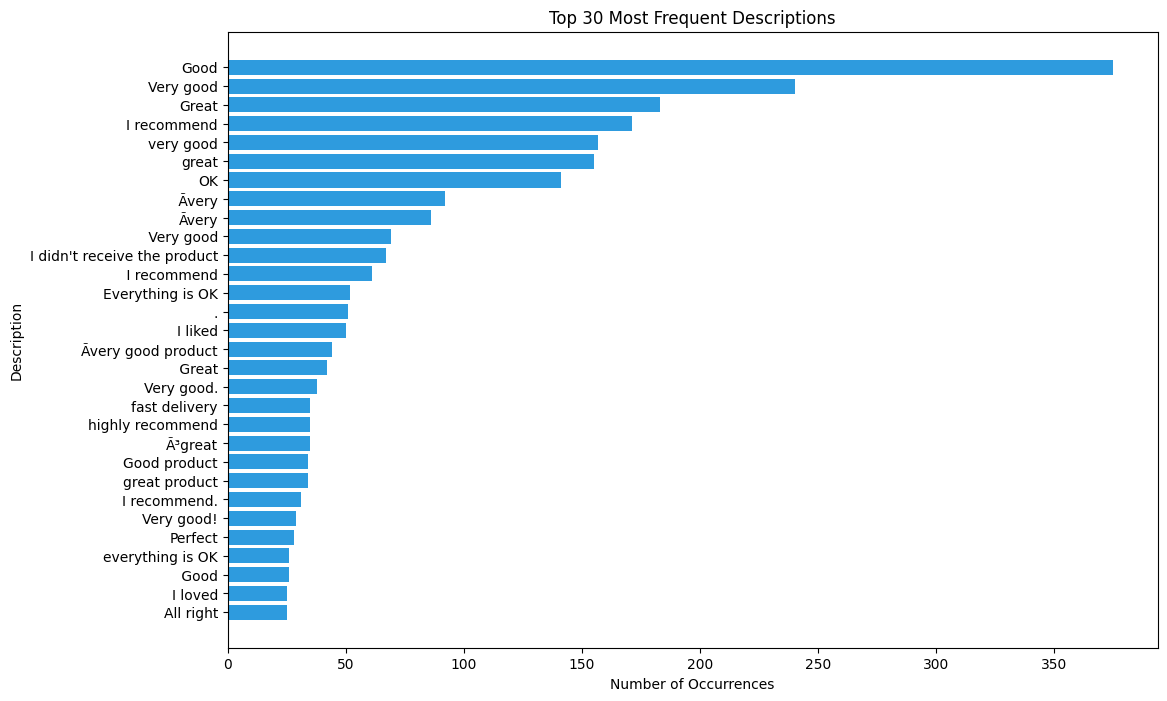

In [ ]:
# Calculate the occurrence of each unique comments and sort them
comments_counts = order_reviews_data['review_comment_message'].value_counts()

# Get the top 30 comments
top_30_comments = comments_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_comments.index[::-1], top_30_comments.values[::-1], color='#2e9bde')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

Most comments are simple words with clear connotation. This can help towards sentiment analysis and recomendations systems.

This data set has not many issues as is information filled by the customers. This also means its quite valuable information, especially the review score as it's a metric the can be sued in order to convince new customer to buy something.

That is why we can plot scores on products or find best and worst products in different categories.

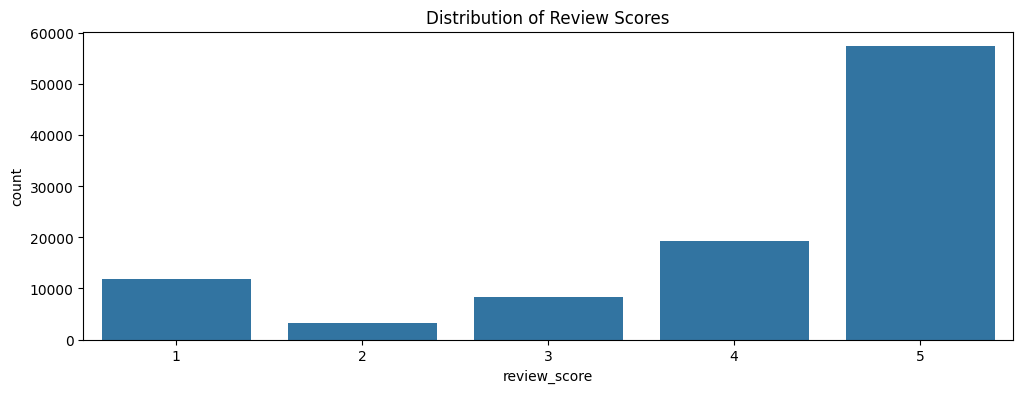

In [ ]:
#Plot the distribution of review scores
plt.figure(figsize=(12,4))
sns.countplot(x='review_score', data=order_reviews_data)
plt.title('Distribution of Review Scores')
plt.show()

We can se how most of the reviews have 5 stars. Still we have to se averages on the products. And see that dsitribution to have a wide uderstanding of how is the store doing from the clients perspective. We will do thi for the 10 best items and the worst 10.

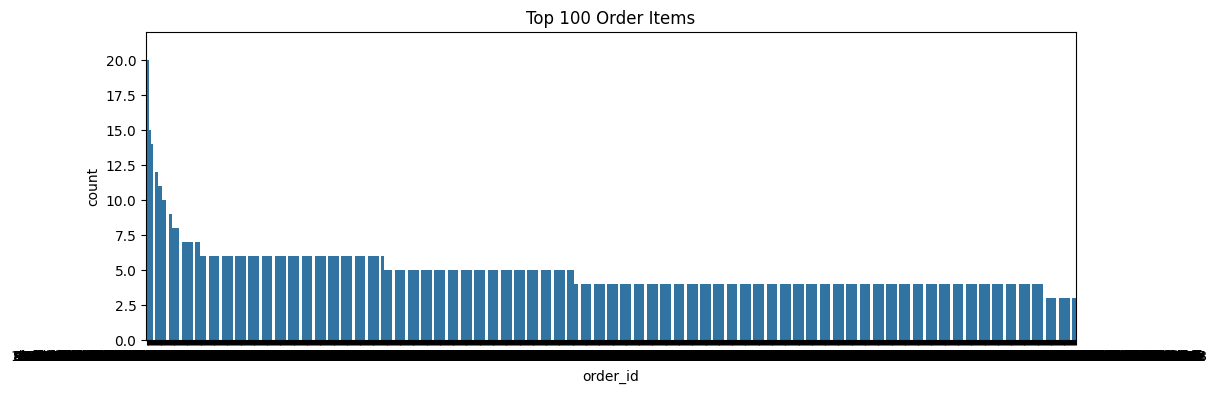

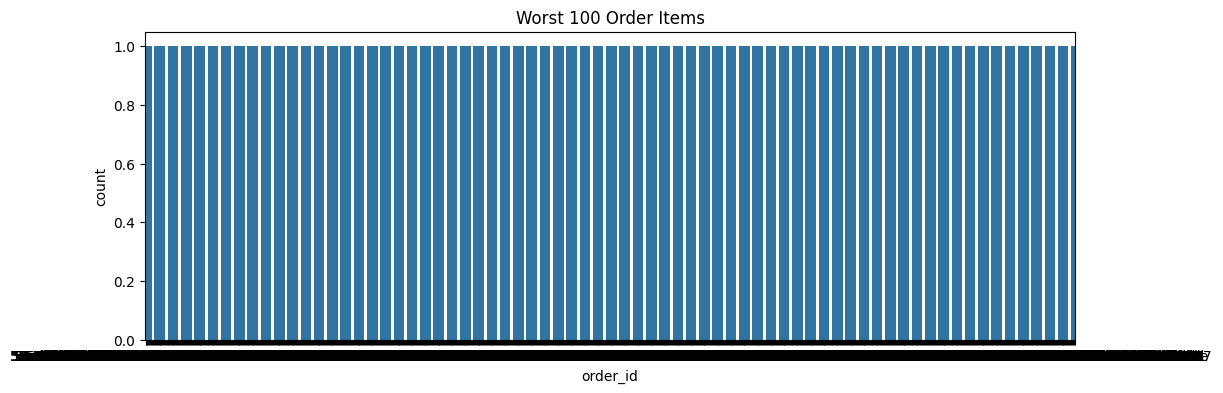

In [ ]:
#Plot of the distribution of the number of review scores per order. 10 Best
plt.figure(figsize=(12,4))
sns.countplot(x='order_id', data=order_item_data, order=order_item_data['order_id'].value_counts().iloc[:1000].index)
plt.title('Top 100 Order Items')
plt.show()

#Plot of the distribution of the number of review scores per order. 10 Worst
plt.figure(figsize=(12,4))
sns.countplot(x='order_id', data=order_item_data, order=order_item_data['order_id'].value_counts().iloc[-1000:].index)
plt.title('Worst 100 Order Items')
plt.show()

We can see how the top 1000 items have been reviewed more than 5 times whereas the worst items just have one review.

## __4. Order payments__

In [ ]:
order_payments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [ ]:
order_payments_data.describe(include='all')

order_id  payment_sequential payment_type  \
count                             103886       103886.000000       103886   
unique                             99440                 NaN            5   
top     fa65dad1b0e818e3ccc5cb0e39231352                 NaN  credit_card   
freq                                  29                 NaN        76795   
mean                                 NaN            1.092679          NaN   
std                                  NaN            0.706584          NaN   
min                                  NaN            1.000000          NaN   
25%                                  NaN            1.000000          NaN   
50%                                  NaN            1.000000          NaN   
75%                                  NaN            1.000000          NaN   
max                                  NaN           29.000000          NaN   

        payment_installments  payment_value  
count          103886.000000  103886.000000  
unique                   NaN            NaN  
top                      NaN            NaN  
freq                     NaN            NaN  
mean                2.853349     154.100380  
std                 2.687051     217.494064  
min                 0.000000       0.000000  
25%                 1.000000      56.790000  
50%                 1.000000     100.000000  
75%                 4.000000     171.837500  
max                24.000000   13664.080000

In [ ]:
order_payments_data.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

No null values, so no further investigation on that.

In [ ]:
order_payments_data['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\2758136918.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='payment_type', data=order_payments_data, palette='crest')


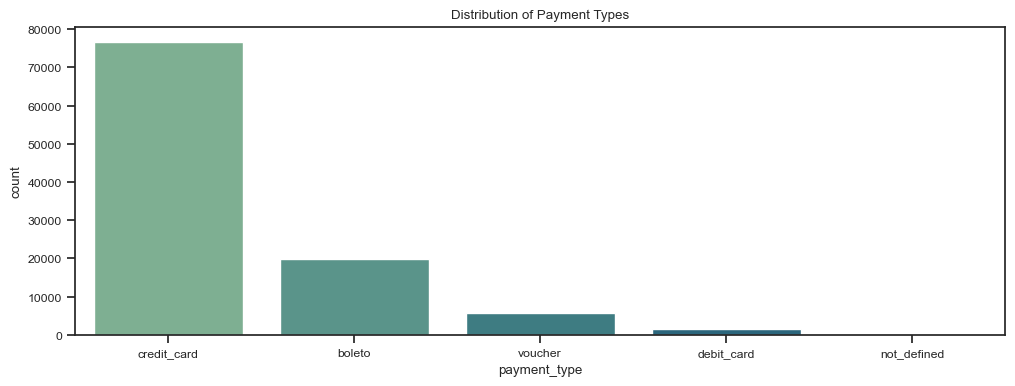

In [ ]:
#Plot the distribution of payment types
plt.figure(figsize=(12,4))
sns.countplot(x='payment_type', data=order_payments_data, palette='crest')
plt.title('Distribution of Payment Types')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\370581276.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(order_payments_data['payment_value'], bins=100, palette='crest', kde=True)


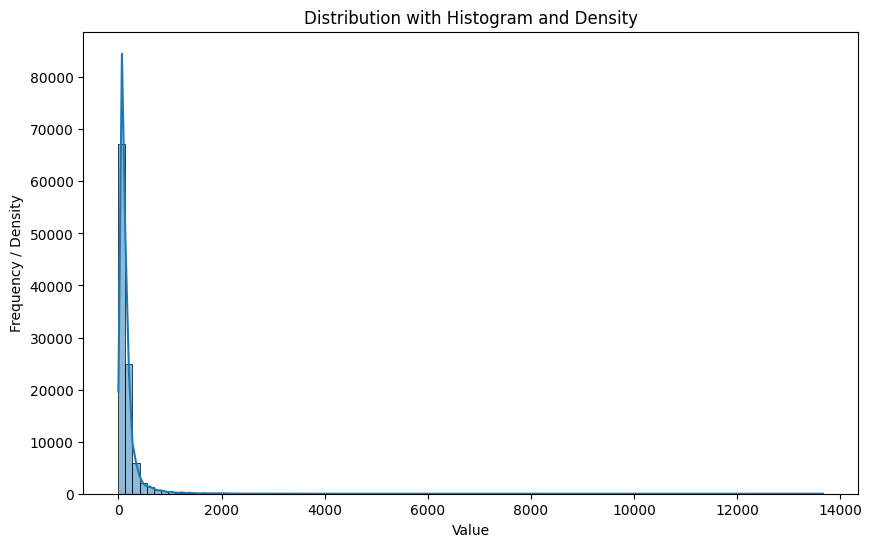

In [ ]:
#Line Plot distribution of payment values
plt.figure(figsize=(10, 6))
sns.histplot(order_payments_data['payment_value'], bins=100, palette='crest', kde=True)
plt.title('Distribution with Histogram and Density')
plt.xlabel('Value')
plt.ylabel('Frequency / Density')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\473822014.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='payment_installments', data=order_payments_data, palette='crest')


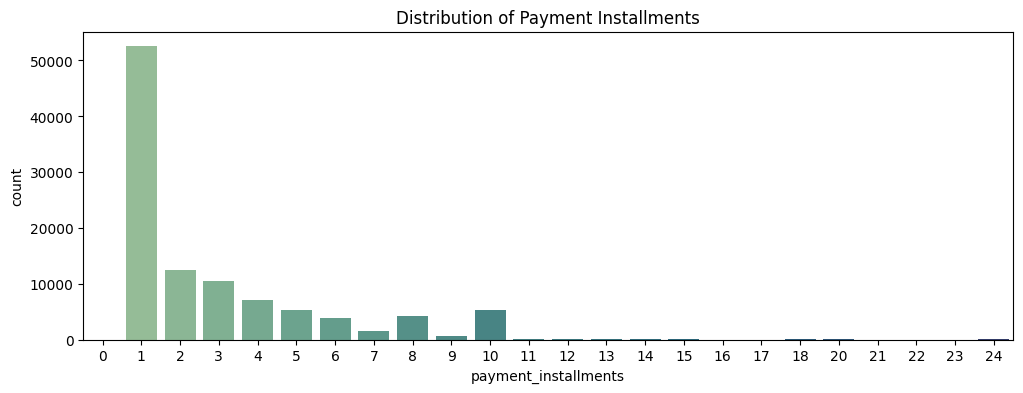

In [ ]:
#Plot distribution of payment installments
plt.figure(figsize=(12,4))
sns.countplot(x='payment_installments', data=order_payments_data, palette='crest')
plt.title('Distribution of Payment Installments')
plt.show()

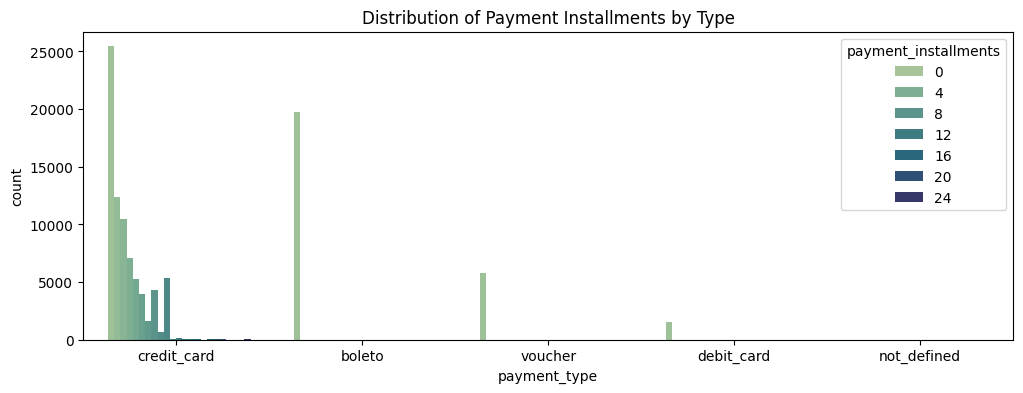

In [ ]:
#Plot crossing payment type and payment installments
plt.figure(figsize=(12,4))
sns.countplot(x='payment_type', hue='payment_installments', data=order_payments_data, palette='crest')
plt.title('Distribution of Payment Installments by Type')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\3076573417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(y='payment_value', x='payment_type', data=order_payments_data, palette='crest')


<Figure size 1200x400 with 0 Axes>

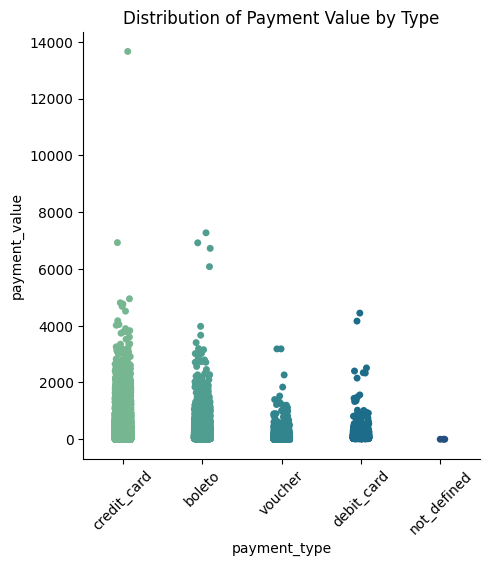

In [ ]:
#scat Plot crossing payment type and payment value
plt.figure(figsize=(12,4))
sns.catplot(y='payment_value', x='payment_type', data=order_payments_data, palette='crest')
plt.title('Distribution of Payment Value by Type')
plt.xticks(rotation=45)
plt.show()

We can apreciate how there is a tendency of paying more expensive things with card over other kinds of ways.

Let's do a bar plot with avg to confirm it.

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\2384356161.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payment_type', y='payment_value', data=order_payments_data, palette='crest')


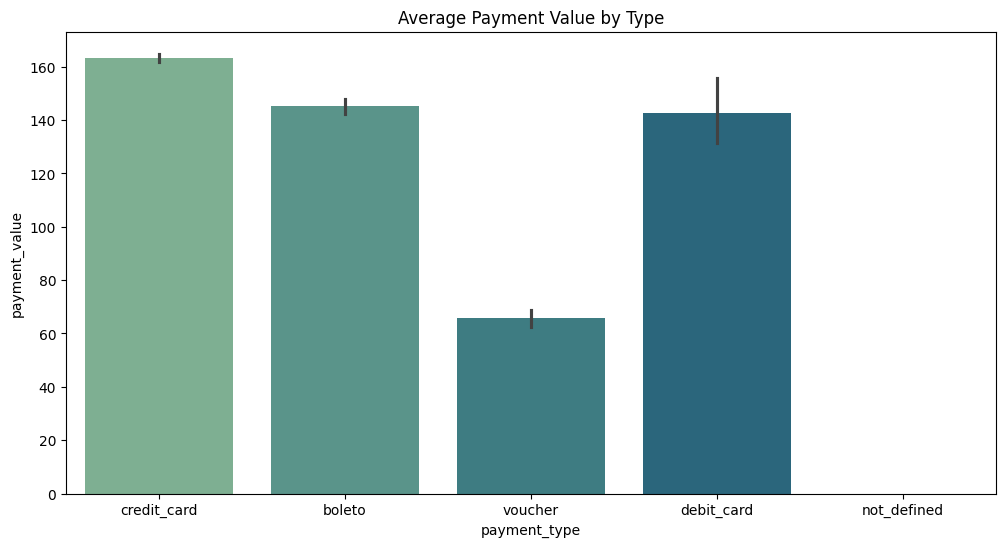

In [ ]:
#Plot avg payment value by type
plt.figure(figsize=(12,6))
sns.barplot(x='payment_type', y='payment_value', data=order_payments_data, palette='crest')
plt.title('Average Payment Value by Type')
plt.show()

As we suspected the avg credit car payment is higher than the rest of them. Another interesting thing is that debit car is used as much as 'boleto' for paying.

In [ ]:
#count not defined values
order_payments_data[order_payments_data['payment_type'] == 'not_defined']

order_id  payment_sequential payment_type  \
51280  4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411  00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
94427  c8c528189310eaa44a745b8d9d26908b                   1  not_defined   

       payment_installments  payment_value  
51280                     1            0.0  
57411                     1            0.0  
94427                     1            0.0

## __5. Order items__

In [ ]:
order_item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


order_item_id is an 'int64' type and it is better to have it as object as it doesn't reflect a measurement of anything is just and id.

In [ ]:
order_item_data['order_item_id'] = order_item_data['order_item_id'].astype(object)

In [ ]:
order_item_data.describe(include='all')

order_id  order_item_id  \
count                             112650       112650.0   
unique                             98666           21.0   
top     8272b63d03f5f79c56e9e4120aec44ef            1.0   
freq                                  21        98666.0   
mean                                 NaN            NaN   
std                                  NaN            NaN   
min                                  NaN            NaN   
25%                                  NaN            NaN   
50%                                  NaN            NaN   
75%                                  NaN            NaN   
max                                  NaN            NaN   

                              product_id                         seller_id  \
count                             112650                            112650   
unique                             32951                              3095   
top     aca2eb7d00ea1a7b8ebd4e68314663af  6560211a19b47992c3666cc44a7e94c0   
freq                                 527                              2033   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

        shipping_limit_date          price  freight_value  
count                112650  112650.000000  112650.000000  
unique                93318            NaN            NaN  
top     2017-07-21 18:25:23            NaN            NaN  
freq                     21            NaN            NaN  
mean                    NaN     120.653739      19.990320  
std                     NaN     183.633928      15.806405  
min                     NaN       0.850000       0.000000  
25%                     NaN      39.900000      13.080000  
50%                     NaN      74.990000      16.260000  
75%                     NaN     134.900000      21.150000  
max                     NaN    6735.000000     409.680000

In [ ]:
order_item_data.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

No missing values, good.

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\1794402104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price', data=order_item_data, palette='crest')


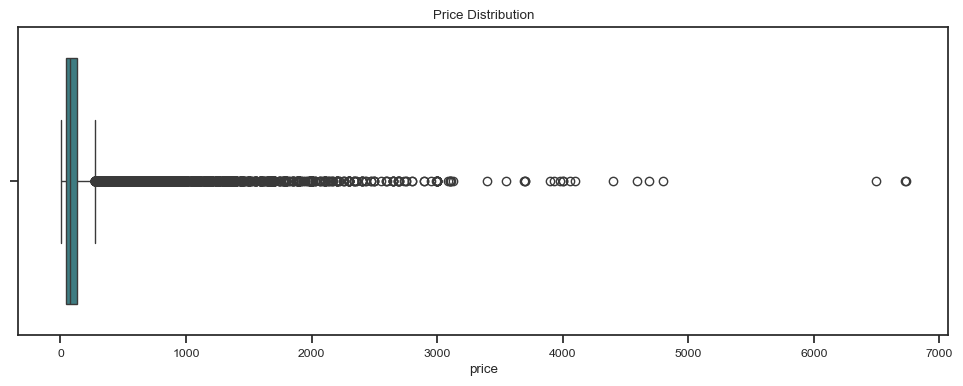

In [ ]:
#Box plot the prices
plt.figure(figsize=(12,4))
sns.boxplot(x='price', data=order_item_data, palette='crest')
plt.title('Price Distribution')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\3816883586.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(order_item_data['price'], bins=100, palette='crest', kde=True)
C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\3816883586.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(order_item_data['freight_value'], bins=100, palette='crest', kde=True)


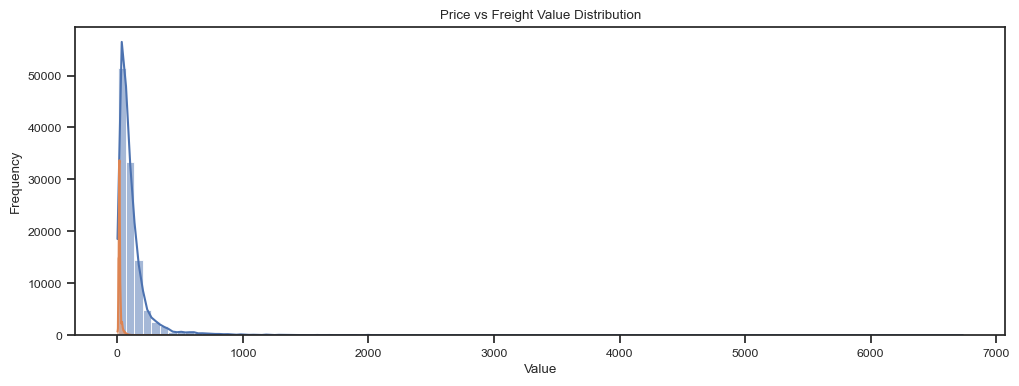

In [ ]:
#Comapre the price distribution with the freight value
plt.figure(figsize=(12,4))
sns.histplot(order_item_data['price'], bins=100, palette='crest', kde=True)
sns.histplot(order_item_data['freight_value'], bins=100, palette='crest', kde=True)
plt.title('Price vs Freight Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
order_item_data['shipping_limit_date'] = pd.to_datetime(order_item_data['shipping_limit_date'])
order_item_data['shipping_limit_date'].head()

0   2017-09-19 09:45:35
1   2017-05-03 11:05:13
2   2018-01-18 14:48:30
3   2018-08-15 10:10:18
4   2017-02-13 13:57:51
Name: shipping_limit_date, dtype: datetime64[ns]

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\3138487233.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(order_item_data['shipping_limit_date'], bins=100, palette='crest', kde=True)


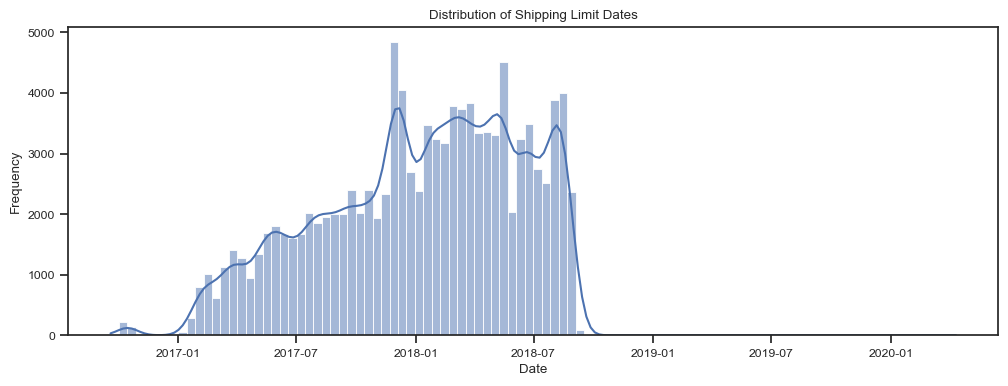

In [ ]:
#Plot the distribution of shipping limit dates
plt.figure(figsize=(12,4))
sns.histplot(order_item_data['shipping_limit_date'], bins=100, palette='crest', kde=True)
plt.title('Distribution of Shipping Limit Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

## __6. Products__ ##

In [ ]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
product_data.describe(include='all')

product_id product_category_name  \
count                              32951                 32341   
unique                             32951                    73   
top     1e9e8ef04dbcff4541ed26657ea517e5       cama_mesa_banho   
freq                                   1                  3029   
mean                                 NaN                   NaN   
std                                  NaN                   NaN   
min                                  NaN                   NaN   
25%                                  NaN                   NaN   
50%                                  NaN                   NaN   
75%                                  NaN                   NaN   
max                                  NaN                   NaN   

        product_name_lenght  product_description_lenght  product_photos_qty  \
count          32341.000000                32341.000000        32341.000000   
unique                  NaN                         NaN                 NaN   
top                     NaN                         NaN                 NaN   
freq                    NaN                         NaN                 NaN   
mean              48.476949                  771.495285            2.188986   
std               10.245741                  635.115225            1.736766   
min                5.000000                    4.000000            1.000000   
25%               42.000000                  339.000000            1.000000   
50%               51.000000                  595.000000            1.000000   
75%               57.000000                  972.000000            3.000000   
max               76.000000                 3992.000000           20.000000   

        product_weight_g  product_length_cm  product_height_cm  \
count       32949.000000       32949.000000       32949.000000   
unique               NaN                NaN                NaN   
top                  NaN                NaN                NaN   
freq                 NaN                NaN                NaN   
mean         2276.472488          30.815078          16.937661   
std          4282.038731          16.914458          13.637554   
min             0.000000           7.000000           2.000000   
25%           300.000000          18.000000           8.000000   
50%           700.000000          25.000000          13.000000   
75%          1900.000000          38.000000          21.000000   
max         40425.000000         105.000000         105.000000   

        product_width_cm  
count       32949.000000  
unique               NaN  
top                  NaN  
freq                 NaN  
mean           23.196728  
std            12.079047  
min             6.000000  
25%            15.000000  
50%            20.000000  
75%            30.000000  
max           118.000000

In [ ]:
product_data['product_category_name'].unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', nan,
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
   

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\232032939.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='product_category_name', data=product_data, order=product_data['product_category_name'].value_counts().index, palette='crest')


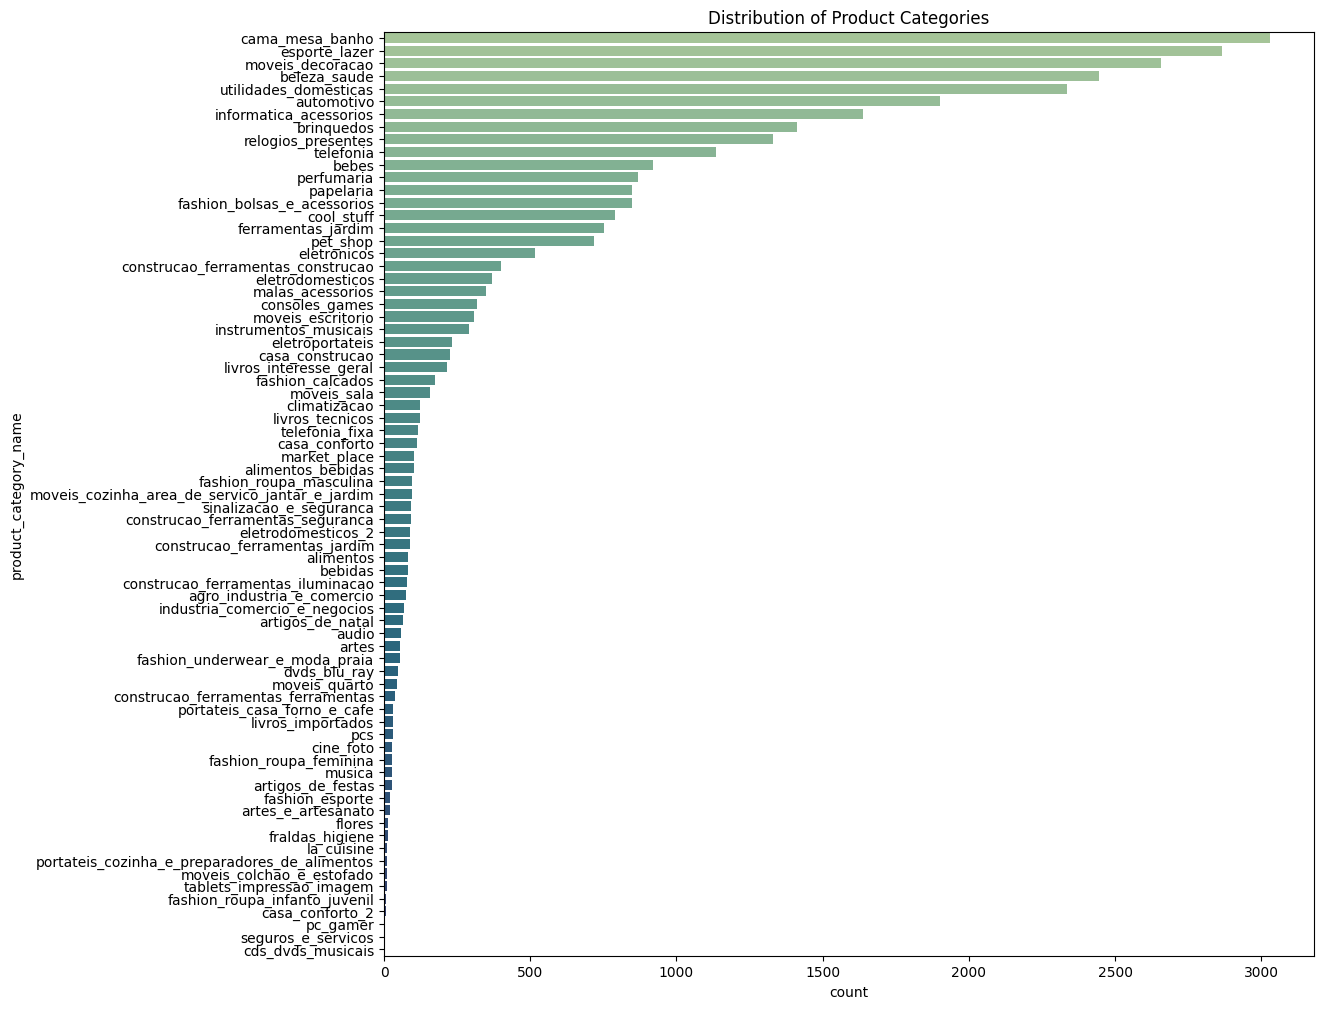

In [ ]:
#Plot the distribution of product categories
plt.figure(figsize=(12,12))
sns.countplot(y='product_category_name', data=product_data, order=product_data['product_category_name'].value_counts().index, palette='crest')
plt.title('Distribution of Product Categories')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\1488329457.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(product_data['product_weight_g'], bins=100, palette='crest', kde=True)


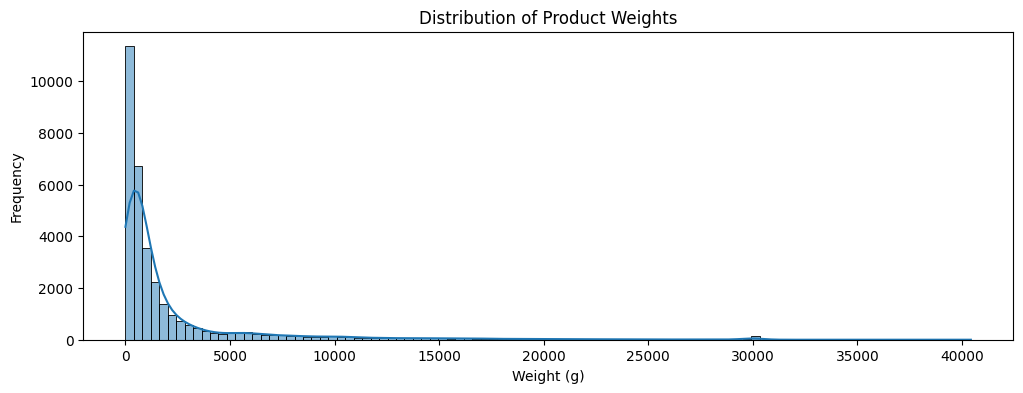

In [ ]:
#Plot the distribution of product weights
plt.figure(figsize=(12,4))
sns.histplot(product_data['product_weight_g'], bins=100, palette='crest', kde=True)
plt.title('Distribution of Product Weights')
plt.xlabel('Weight (g)')
plt.ylabel('Frequency')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\3425832993.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(product_data['product_length_cm'], bins=100, palette='crest', kde=True)


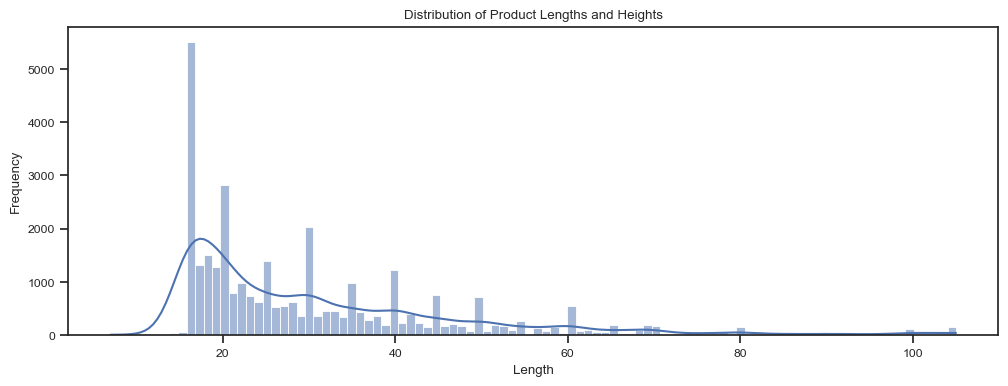

In [ ]:
#Plot the distribution of product lengths
plt.figure(figsize=(12,4))
sns.histplot(product_data['product_length_cm'], bins=100, palette='crest', kde=True)
plt.title('Distribution of Product Lengths and Heights')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\571678323.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(product_data['product_width_cm'], bins=100, palette='crest', kde=True)


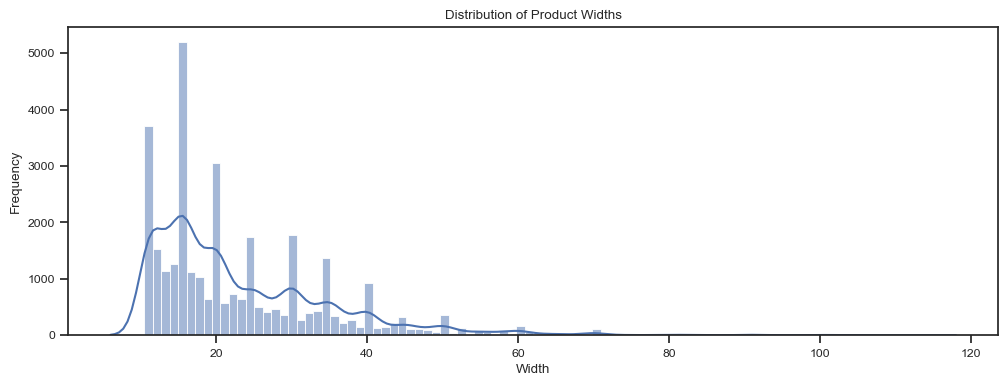

In [ ]:
# Plot the distribution of product widths
plt.figure(figsize=(12, 4))
sns.histplot(product_data['product_width_cm'], bins=100, palette='crest', kde=True)
plt.title('Distribution of Product Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\3496787496.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='product_weight_g', data=product_data, palette='crest')


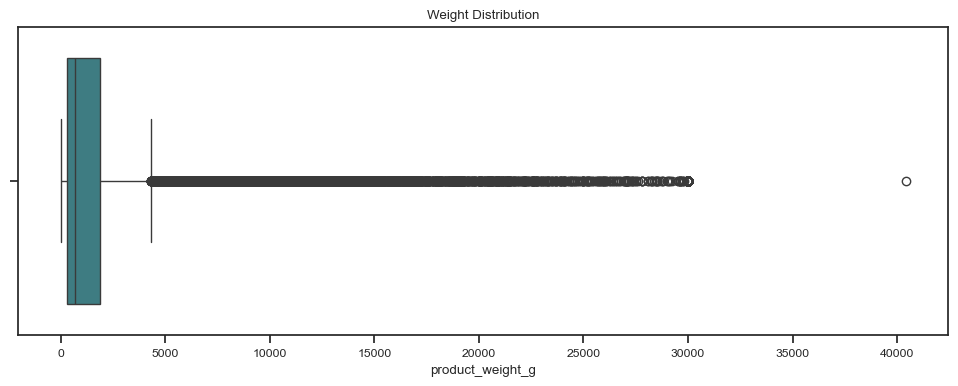

In [ ]:
#bosx Plot distribution of weight
plt.figure(figsize=(12,4))
sns.boxplot(x='product_weight_g', data=product_data, palette='crest')
plt.title('Weight Distribution')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\2509150717.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(product_data['product_length_cm'], bins=100, palette='crest', kde=True)
C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\2509150717.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(product_data['product_width_cm'], bins=100, palette='crest', kde=True)
C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_5748\2509150717.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(product_data['product_height_cm'], bins=100, palette='crest', kde=True)


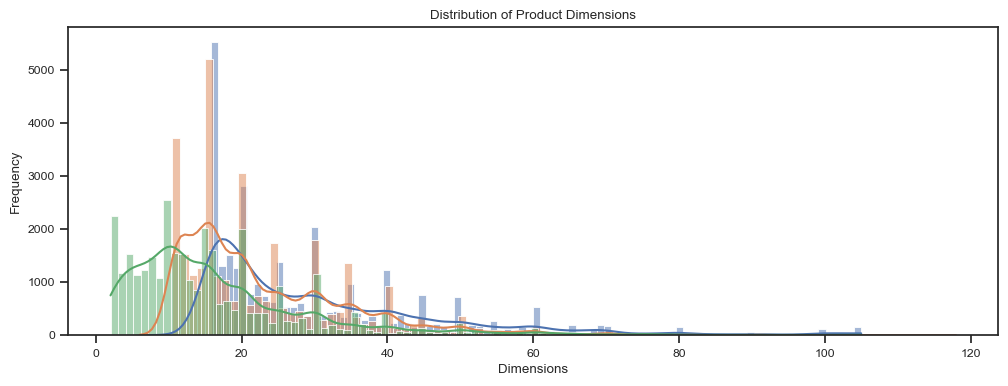

In [ ]:
#Distribution of product dimensions
plt.figure(figsize=(12,4))
sns.histplot(product_data['product_length_cm'], bins=100, palette='crest', kde=True)
sns.histplot(product_data['product_width_cm'], bins=100, palette='crest', kde=True)
sns.histplot(product_data['product_height_cm'], bins=100, palette='crest', kde=True)
plt.title('Distribution of Product Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.show()

From this plot w can take that most objects have similar length and with but different height, so they are quite squared boxes.

## __7. Seller__

In [ ]:
seller_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [ ]:
seller_data['seller_zip_code_prefix'] = seller_data['seller_zip_code_prefix'].astype(object)
seller_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   object
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: object(4)
memory usage: 96.8+ KB


In [ ]:
seller_data.describe(include='all')

seller_id  seller_zip_code_prefix seller_city  \
count                               3095                    3095        3095   
unique                              3095                    2246         611   
top     3442f8959a84dea7ee197c632cb2df15                   14940   sao paulo   
freq                                   1                      49         694   

       seller_state  
count          3095  
unique           23  
top              SP  
freq           1849

In [ ]:
seller_data.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

No null values.

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\439126883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='seller_state', data=seller_data, palette='crest')


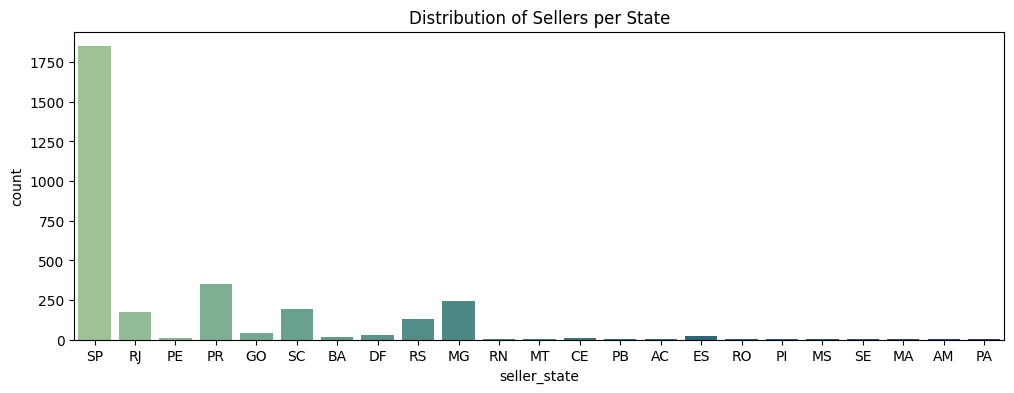

In [ ]:
#Plot the distribution of seller states
plt.figure(figsize=(12,4))
sns.countplot(x='seller_state', data=seller_data, palette='crest')
plt.title('Distribution of Sellers per State')
plt.show()

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\2711324872.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sns.countplot(x='seller_city', data=seller_data, order=pd.value_counts(seller_data['seller_city']).iloc[:10].index, palette='crest')
C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\2711324872.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='seller_city', data=seller_data, order=pd.value_counts(seller_data['seller_city']).iloc[:10].index, palette='crest')


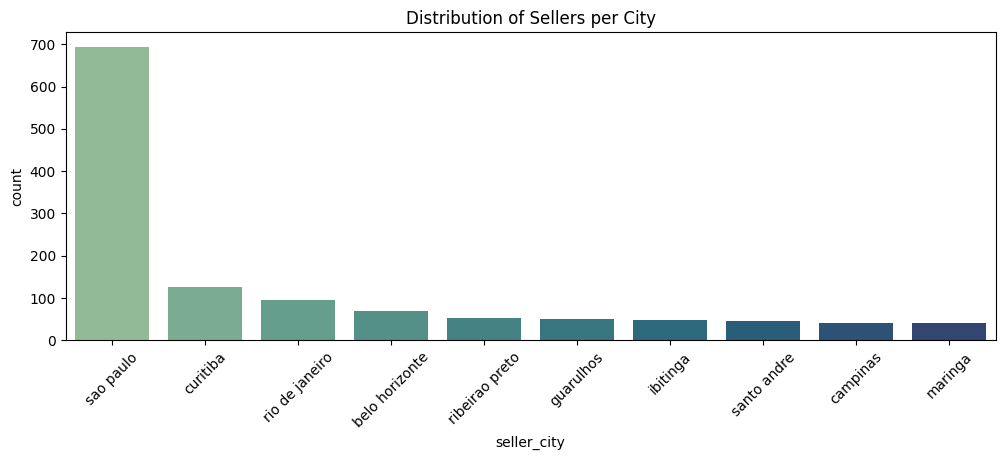

In [ ]:
#Plot the distribution of seller cities, make bars same color if its the same as the state
plt.figure(figsize=(12,4))
sns.countplot(x='seller_city', data=seller_data, order=pd.value_counts(seller_data['seller_city']).iloc[:10].index, palette='crest')
plt.title('Distribution of Sellers per City')
plt.xticks(rotation=45)
plt.show()

## __8. Geolocation__

In [ ]:
geolocation_data.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [ ]:
geolocation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [ ]:
geolocation_data.describe(include='all')

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
count                  1.000163e+06     1.000163e+06     1.000163e+06   
unique                          NaN              NaN              NaN   
top                             NaN              NaN              NaN   
freq                            NaN              NaN              NaN   
mean                   3.657417e+04    -2.117615e+01    -4.639054e+01   
std                    3.054934e+04     5.715866e+00     4.269748e+00   
min                    1.001000e+03    -3.660537e+01    -1.014668e+02   
25%                    1.107500e+04    -2.360355e+01    -4.857317e+01   
50%                    2.653000e+04    -2.291938e+01    -4.663788e+01   
75%                    6.350400e+04    -1.997962e+01    -4.376771e+01   
max                    9.999000e+04     4.506593e+01     1.211054e+02   

       geolocation_city geolocation_state  
count           1000163           1000163  
unique             8011                27  
top           sao paulo                SP  
freq             135800            404268  
mean                NaN               NaN  
std                 NaN               NaN  
min                 NaN               NaN  
25%                 NaN               NaN  
50%                 NaN               NaN  
75%                 NaN               NaN  
max                 NaN               NaN

In [ ]:
geolocation_data.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

C:\Users\Jorge Esteban\AppData\Local\Temp\ipykernel_27252\1630468486.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=geolocation_data, palette='crest')


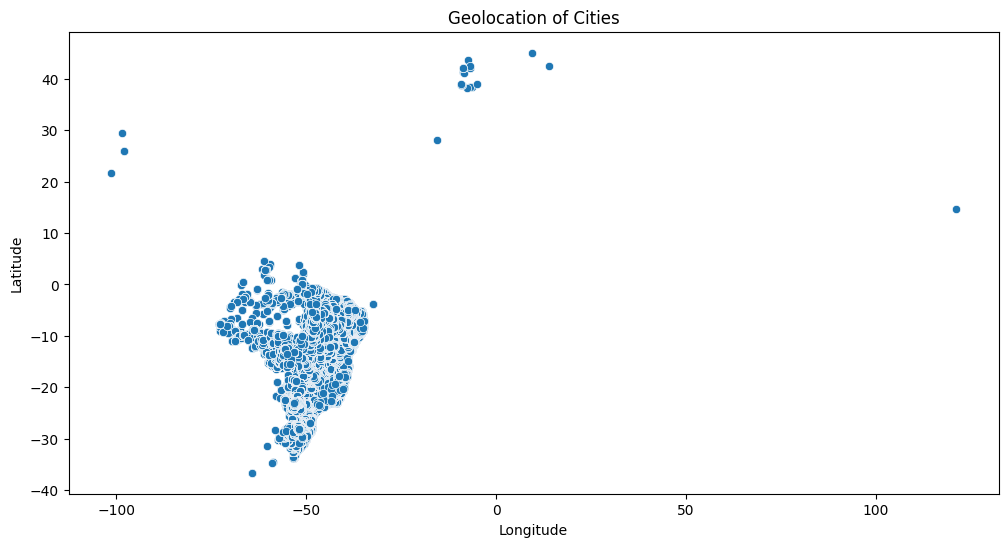

In [ ]:
#Plot map of cities
plt.figure(figsize=(12,6))
sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=geolocation_data, palette='crest')
plt.title('Geolocation of Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

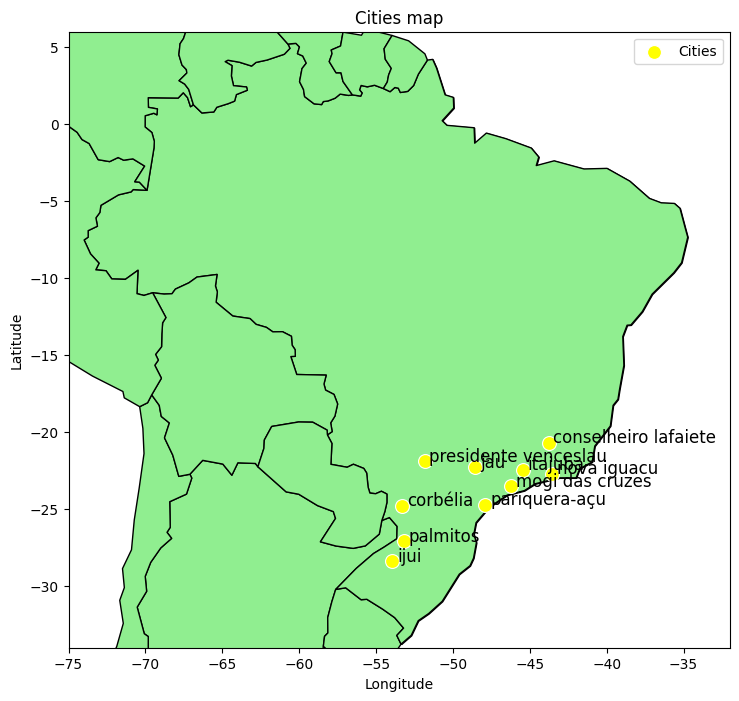

In [ ]:
# URL of the shapefile
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

# Read the shapefile
world = gpd.read_file(url)
brazil = world[world['NAME'] == 'Brazil']

# Example data: 10 random cities
data = geolocation_data.sample(10)


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

brazil.plot(ax=ax, color='lightgrey', edgecolor='black')

# Draw the world map
world.plot(ax=ax, color='lightgreen', edgecolor='black')


# Grapgical representation of the cities
sns.scatterplot(
    x='geolocation_lng', y='geolocation_lat', data=data, ax=ax,
    color='yellow', s=100, label='Cities'
)

# Add city names to the plot
for i, row in data.iterrows():
    ax.text(row['geolocation_lng'] + 0.3, row['geolocation_lat'], row['geolocation_city'], fontsize=12)

# Customize the plot
ax.set_title('Cities map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-75, -32)   # Longitud
ax.set_ylim(-34, 6)     # Latitud
plt.legend(scatterpoints=1, frameon=True, labelspacing=1)
plt.show()

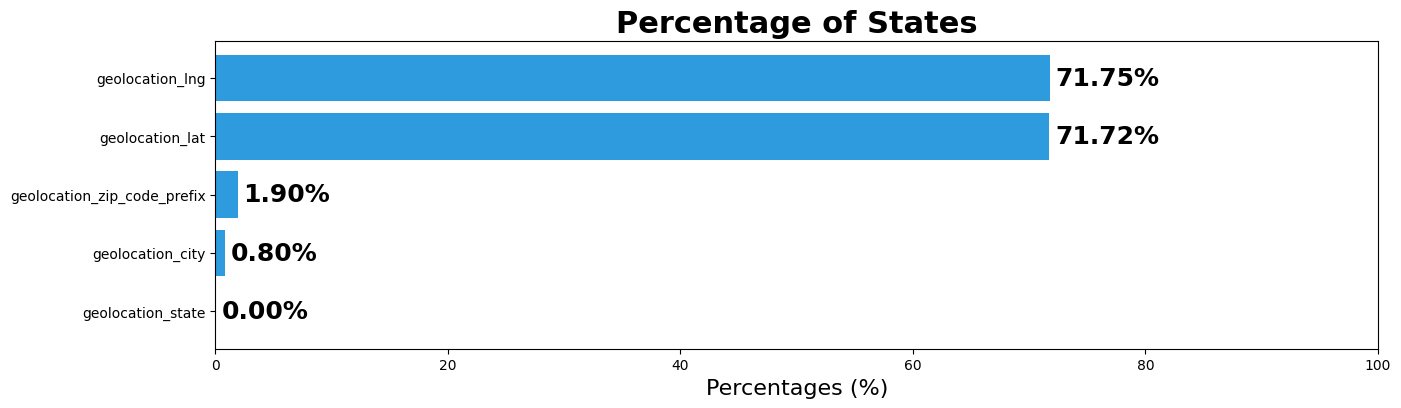

In [ ]:
# Calculating the percentage of states
state_percentage = (geolocation_data.nunique() / geolocation_data.shape[0]) * 100

# Prepare values
state_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(state_percentage.index, state_percentage, color='#2e9bde')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(state_percentage, state_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 100])

# Add title and xlabel
plt.title("Percentage of States", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

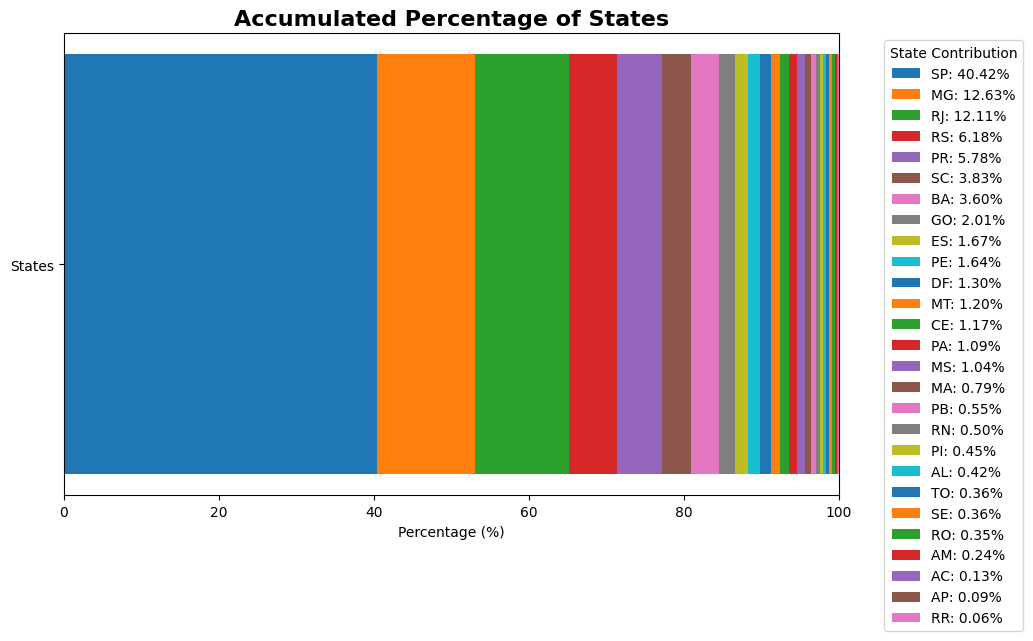

In [ ]:
# Calculating the percentage of states
state_counts = geolocation_data['geolocation_state'].value_counts()
total_state_count = geolocation_data['geolocation_state'].count()
state_percentage = (state_counts / total_state_count) * 100

# Generate distinct colors for each state using a more distinct color palette
colors = sns.color_palette("tab10", len(state_percentage))

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(["States"], [100], color='lightgray')  # Background for full 100%
left = 0
for (state, percent), color in zip(state_percentage.items(), colors):
    ax.barh(["States"], [percent], left=left, color=color, label=f"{state}: {percent:.2f}%")
    left += percent

# Add legend with state names
ax.legend(title="State Contribution", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title and labels
plt.title("Accumulated Percentage of States", fontweight='bold', fontsize=16)
plt.xlabel("Percentage (%)")
plt.xlim([0, 100])
plt.show()


## __Merge into one dataset and cleaning it__ ##

To run this customer segmentation the plan is to analyse the different groups of customer and their shopping habits. It's important to consider multiple factors that could affect this, location, money expent, category etc...

For this matter a merged data set with all the important information is created.

In [ ]:
order_customer = order_data.merge(customer_data, on = 'customer_id')
order_customer.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  delivery_time purchase_day_of_week  \
0                    2017-10-18            2.0               Monday   
1                    2018-08-13            1.0              Tuesday   
2                    2018-09-04            0.0            Wednesday   
3                    2017-12-15            3.0             Saturday   
4                    2018-02-26            0.0              Tuesday   

   purchase_hour                customer_unique_id customer_zip_code_prefix  \
0             10  7c396fd4830fd04220f754e42b4e5bff                     3149   
1             20  af07308b275d755c9edb36a90c618231                    47813   
2              8  3a653a41f6f9fc3d2a113cf8398680e8                    75265   
3             19  7c142cf63193a1473d2e66489a9ae977                    59296   
4             21  72632f0f9dd73dfee390c9b22eb56dd6                     9195   

             customer_city customer_state  
0                sao paulo             SP  
1                barreiras             BA  
2               vianopolis             GO  
3  sao goncalo do amarante             RN  
4              santo andre             SP

In [ ]:
df_full = order_customer.merge(order_payments_data, on = 'order_id')
df_full.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  delivery_time purchase_day_of_week  \
0                    2017-10-18            2.0               Monday   
1                    2017-10-18            2.0               Monday   
2                    2017-10-18            2.0               Monday   
3                    2018-08-13            1.0              Tuesday   
4                    2018-09-04            0.0            Wednesday   

   purchase_hour                customer_unique_id customer_zip_code_prefix  \
0             10  7c396fd4830fd04220f754e42b4e5bff                     3149   
1             10  7c396fd4830fd04220f754e42b4e5bff                     3149   
2             10  7c396fd4830fd04220f754e42b4e5bff                     3149   
3             20  af07308b275d755c9edb36a90c618231                    47813   
4              8  3a653a41f6f9fc3d2a113cf8398680e8                    75265   

  customer_city customer_state  payment_sequential payment_type  \
0     sao paulo             SP                   1  credit_card   
1     sao paulo             SP                   3      voucher   
2     sao paulo             SP                   2      voucher   
3     barreiras             BA                   1       boleto   
4    vianopolis             GO                   1  credit_card   

   payment_installments  payment_value  
0                     1          18.12  
1                     1           2.00  
2                     1          18.59  
3                     1         141.46  
4                     3         179.12

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103886 non-null  object        
 1   customer_id                    103886 non-null  object        
 2   order_status                   103886 non-null  object        
 3   order_purchase_timestamp       103886 non-null  datetime64[ns]
 4   order_approved_at              103711 non-null  datetime64[ns]
 5   order_delivered_carrier_date   101998 non-null  datetime64[ns]
 6   order_delivered_customer_date  100754 non-null  datetime64[ns]
 7   order_estimated_delivery_date  103886 non-null  datetime64[ns]
 8   delivery_time                  101998 non-null  float64       
 9   purchase_day_of_week           103886 non-null  object        
 10  purchase_hour                  103886 non-null  int32         
 11  

In [ ]:
df_full['order_status'].value_counts()

order_status
delivered      100756
shipped          1166
canceled          664
unavailable       649
invoiced          325
processing        319
created             5
approved            2
Name: count, dtype: int64

In [ ]:
#Removing cancelled orders
df_full = df_full[df_full['order_status'] == 'delivered']
df_full['order_status'].value_counts()

order_status
delivered    100756
Name: count, dtype: int64

Some columns won't be needed so it's better to delete them as this will lower the cost of executing all this process.

In [ ]:
column_name = df_full.columns
column_name

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time', 'purchase_day_of_week', 'purchase_hour',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [ ]:
#Dropping columns
df_full = df_full.drop(['order_status','order_purchase_timestamp'], axis = 1)
df_full = df_full.drop(column_name[5:13], axis = 1)
df_full

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
103881  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
103882  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
103883  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
103884  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
103885  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

         order_approved_at        customer_city customer_state  \
0      2017-10-02 11:07:15            sao paulo             SP   
1      2017-10-02 11:07:15            sao paulo             SP   
2      2017-10-02 11:07:15            sao paulo             SP   
3      2018-07-26 03:24:27            barreiras             BA   
4      2018-08-08 08:55:23           vianopolis             GO   
...                    ...                  ...            ...   
103881 2017-03-09 09:54:05  sao jose dos campos             SP   
103882 2018-02-06 13:10:37         praia grande             SP   
103883 2017-08-27 15:04:16          nova vicosa             BA   
103884 2018-01-08 21:36:21              japuiba             RJ   
103885 2018-03-09 11:20:28                 lapa             PR   

        payment_sequential payment_type  payment_installments  payment_value  
0                        1  credit_card                     1          18.12  
1                        3      voucher                     1           2.00  
2                        2      voucher                     1          18.59  
3                        1       boleto                     1         141.46  
4                        1  credit_card                     3         179.12  
...                    ...          ...                   ...            ...  
103881                   1  credit_card                     3          85.08  
103882                   1  credit_card                     3         195.00  
103883                   1  credit_card                     5         271.01  
103884                   1  credit_card                     4         441.16  
103885                   1   debit_card                     1          86.86  

[100756 rows x 9 columns]

In [ ]:
len(df_full['customer_state'].unique())

27

This dataset is almost ready, its outliers need to be checked so the information is more reliable.

__Check Outliers:__

In [ ]:
df_full['payment_value'].describe()

count    100756.000000
mean        153.067428
std         214.451418
min           0.000000
25%          56.780000
50%         100.000000
75%         171.290000
max       13664.080000
Name: payment_value, dtype: float64

In [ ]:
Q1 = df_full['payment_value'].quantile(0.25)
Q3 = df_full['payment_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
out_list = df_full.index[(df_full['payment_value'] < lower_bound) | (df_full['payment_value'] > upper_bound)]
out_list = sorted(set(out_list))
print('There are ' + str(len(out_list)) + ' outliers')
print('Now lets see if we need to remove it or not')

There are 7698 outliers
Now lets see if we need to remove it or not


The analysis that I'm looking for are:

- Number of monthly order (count)
- Daily order trend (count)
- Orders per payment type (count)

Considering that, the value of payment will not affect the results. The outliers will be kept for this reason. However, later on clustering analysis outliers might need to be removed

__Visualization:__

In [ ]:
order_monthly = df_full[['order_approved_at']].groupby(df_full['order_approved_at'].dt.to_period('M')).agg({'order_approved_at':'count'})
order_monthly.head()

order_approved_at
order_approved_at                   
2016-10                          282
2016-12                            1
2017-01                          763
2017-02                         1735
2017-03                         2708

In [ ]:
#Change the column name to num_of_orders
order_monthly = order_monthly.rename(columns = {'order_approved_at': 'num_of_orders'})
#Changing order_approved_at to column, not an index
order_monthly = order_monthly.reset_index()

#adding column for month name and year
order_monthly['month_year'] = order_monthly['order_approved_at'].dt.strftime('%b-%Y')
order_monthly.head()

ValueError: cannot insert level_0, already exists

In [ ]:
plt.figure(figsize=(17,8))
sns.set_theme(style="ticks", font_scale=0.7)
order_monthly_viz = sns.lineplot(x = 'month_year', y = 'num_of_orders', data = order_monthly)
order_monthly_viz.set_title('Number of Order per Month 2016-2018',fontsize = 20)
order_monthly_viz.set_xlabel('Month-Year',fontsize = 14)
order_monthly_viz.set_ylabel('Number of Orders',fontsize = 14)
plt.show()

ValueError: 2

<Figure size 1700x800 with 0 Axes>

Function to visualize monthly order per year

In [ ]:
def call_monthly_order (df,year):
  df_year = df[df['order_approved_at'].dt.year == year]
  df_year = df_year[['month_year','num_of_orders']]
  sns.set(rc = {'figure.figsize':(10,4)})
  sns.set_theme(style="ticks", font_scale=0.8)
  visualize = sns.lineplot(x = 'month_year', y = 'num_of_orders', data = df_year)
  visualize.set_title('Number of Order per Month in '+ str(year), fontsize = 17)
  visualize.set_xlabel('Month',fontsize = 13)
  visualize.set_ylabel('Number of Orders', fontsize = 13)
  return visualize

In [ ]:
orders_2017 = call_monthly_order(order_monthly,2017)

KeyError: 'order_approved_at'

In [ ]:
orders_2018 = call_monthly_order(order_monthly,2018)

KeyError: 'order_approved_at'

## __Insights__ ##

Some insights we get from all the explanatory analysis and data cleaning above:

1. The number of sales grew significantly in 2017

2. On June 2018 the sales dropped

3. Customers makes the most order on Tuesday, while Sunday is the least favourite

4. Credit card is the most preferrable payment type, while the usage of debit card is the lowest (only 1% out of 100k+ orders)

# __Customer segmentation__ #

In [ ]:
df_clean = df_full.drop(out_list, axis = 0)
df_clean.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

    order_approved_at customer_city customer_state  payment_sequential  \
0 2017-10-02 11:07:15     sao paulo             SP                   1   
1 2017-10-02 11:07:15     sao paulo             SP                   3   
2 2017-10-02 11:07:15     sao paulo             SP                   2   
3 2018-07-26 03:24:27     barreiras             BA                   1   
4 2018-08-08 08:55:23    vianopolis             GO                   1   

  payment_type  payment_installments  payment_value  
0  credit_card                     1          18.12  
1      voucher                     1           2.00  
2      voucher                     1          18.59  
3       boleto                     1         141.46  
4  credit_card                     3         179.12

### __Creating RFM Score__

We will use because it helps analyze customer behavior by evaluating Recency, Frequency, and Monetary value. This allows businesses to segment customers effectively, personalize marketing strategies, and improve customer retention by identifying high-value customers and predicting future purchasing patterns.


* ⌛ __R = Recency:__ The number of months since the member's last payment from the end of the observation time.

* 📈 __F = Frequency:__ The total number of orders during the observation period.

* 💵 __M = Monetary:__ Payment value during the user's observation time.

In [ ]:
max_date = df_clean.groupby('customer_id')['order_approved_at'].max().reset_index()
max_date = max_date.rename({'order_approved_at':'most_recent'},axis = 1)
max_date.head()

customer_id         most_recent
0  00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:35:32
1  000161a058600d5901f007fab4c27140 2017-07-16 09:55:12
2  0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:15:20
3  0002414f95344307404f0ace7a26f1d5 2017-08-17 03:10:27
4  000379cdec625522490c315e70c7a9fb 2018-04-04 03:10:19

In [ ]:
max_date['r_score'] = (max_date['most_recent'].max() - max_date['most_recent']).dt.days
max_date.head()

customer_id         most_recent  r_score
0  00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:35:32    287.0
1  000161a058600d5901f007fab4c27140 2017-07-16 09:55:12    409.0
2  0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:15:20    547.0
3  0002414f95344307404f0ace7a26f1d5 2017-08-17 03:10:27    377.0
4  000379cdec625522490c315e70c7a9fb 2018-04-04 03:10:19    147.0

__F = Frequency__




In [ ]:
n_transaction = df_clean.groupby('customer_id')['order_id'].count().reset_index()
n_transaction = n_transaction.rename({'order_id':'f_score'},axis = 1)
n_transaction.head()

customer_id  f_score
0  00012a2ce6f8dcda20d059ce98491703        1
1  000161a058600d5901f007fab4c27140        1
2  0001fd6190edaaf884bcaf3d49edf079        1
3  0002414f95344307404f0ace7a26f1d5        1
4  000379cdec625522490c315e70c7a9fb        1

__M = Monetary__



In [ ]:
avg_purchase = df_clean.groupby('customer_id')['payment_value'].mean().reset_index()
avg_purchase = avg_purchase.rename({'payment_value':'m_score'},axis = 1)
avg_purchase.head()

customer_id  m_score
0  00012a2ce6f8dcda20d059ce98491703   114.74
1  000161a058600d5901f007fab4c27140    67.41
2  0001fd6190edaaf884bcaf3d49edf079   195.42
3  0002414f95344307404f0ace7a26f1d5   179.35
4  000379cdec625522490c315e70c7a9fb   107.01

In [ ]:
avg_purchase['customer_id'].nunique()

88913

This indicates there are 88893 unique customers.

In [ ]:
merge = max_date.merge(n_transaction, how = 'left', on = 'customer_id')
merge = merge.merge(avg_purchase, how = 'left', on = 'customer_id')
merge

customer_id         most_recent  r_score  f_score  \
0      00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:35:32    287.0        1   
1      000161a058600d5901f007fab4c27140 2017-07-16 09:55:12    409.0        1   
2      0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:15:20    547.0        1   
3      0002414f95344307404f0ace7a26f1d5 2017-08-17 03:10:27    377.0        1   
4      000379cdec625522490c315e70c7a9fb 2018-04-04 03:10:19    147.0        1   
...                                 ...                 ...      ...      ...   
88908  fffcb937e9dd47a13f05ecb8290f4d3e 2018-03-17 01:35:21    165.0        1   
88909  fffecc9f79fd8c764f843e9951b11341 2018-03-29 17:10:27    152.0        3   
88910  fffeda5b6d849fbd39689bb92087f431 2018-05-22 13:54:37     99.0        1   
88911  ffff42319e9b2d713724ae527742af25 2018-06-13 17:20:23     76.0        1   
88912  ffffa3172527f765de70084a7e53aae8 2017-09-02 12:05:40    361.0        1   

       m_score  
0       114.74  
1        67.41  
2       195.42  
3       179.35  
4       107.01  
...        ...  
88908    91.91  
88909    27.12  
88910    63.13  
88911   214.13  
88912    45.50  

[88913 rows x 5 columns]

In [ ]:
df_rfm = merge[['customer_id','r_score','f_score','m_score']]
df_rfm

customer_id  r_score  f_score  m_score
0      00012a2ce6f8dcda20d059ce98491703    287.0        1   114.74
1      000161a058600d5901f007fab4c27140    409.0        1    67.41
2      0001fd6190edaaf884bcaf3d49edf079    547.0        1   195.42
3      0002414f95344307404f0ace7a26f1d5    377.0        1   179.35
4      000379cdec625522490c315e70c7a9fb    147.0        1   107.01
...                                 ...      ...      ...      ...
88908  fffcb937e9dd47a13f05ecb8290f4d3e    165.0        1    91.91
88909  fffecc9f79fd8c764f843e9951b11341    152.0        3    27.12
88910  fffeda5b6d849fbd39689bb92087f431     99.0        1    63.13
88911  ffff42319e9b2d713724ae527742af25     76.0        1   214.13
88912  ffffa3172527f765de70084a7e53aae8    361.0        1    45.50

[88913 rows x 4 columns]

### __K-Means to Cluster__

In [ ]:
features = df_rfm.drop('customer_id',axis = 1)
scale = StandardScaler()
features_scaled = scale.fit_transform(features)
features_scaled

array([[ 0.31748702, -0.12194792,  0.02629561],
       [ 1.11727598, -0.12194792, -0.63561895],
       [ 2.02195531, -0.12194792,  1.15461309],
       ...,
       [-0.91497467, -0.12194792, -0.69547515],
       [-1.06575456, -0.12194792,  1.41627422],
       [ 0.80260491, -0.12194792, -0.94203238]])

In [ ]:
# Handle NaN values before scaling
features = df_rfm.drop('customer_id', axis=1)
# Impute NaN values with the mean of each column
features = features.fillna(features.mean())

scale = StandardScaler()
features_scaled = scale.fit_transform(features)

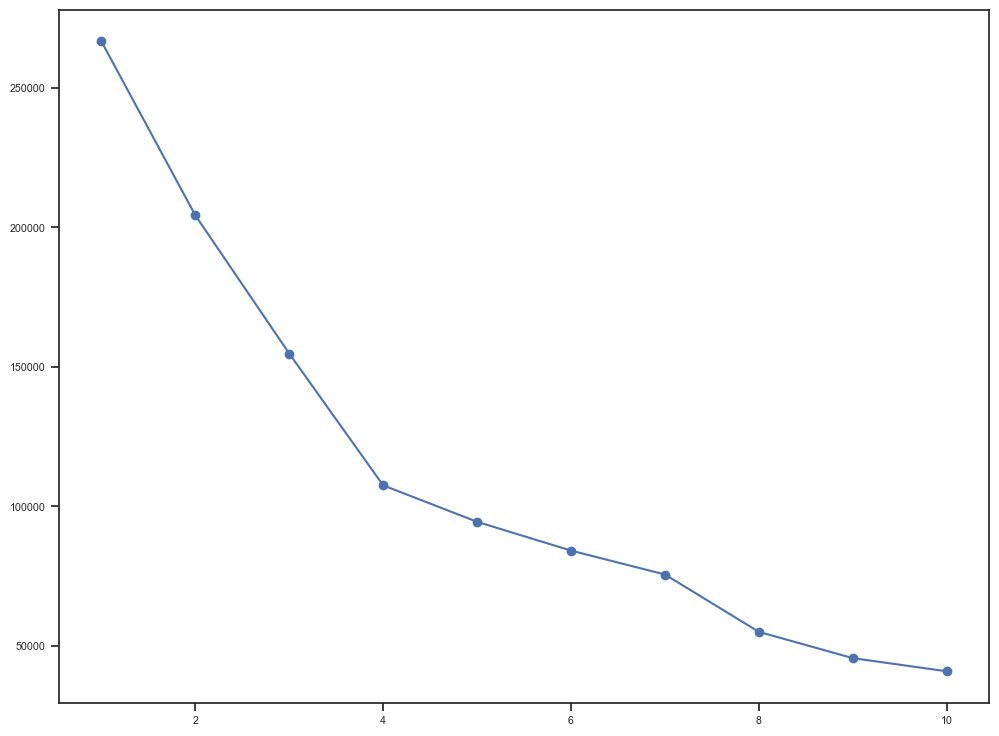

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 9))
plt.plot(range(1, 11), wcss, marker='o')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++',random_state = 1)
kmeans.fit(features_scaled)
df_seg_kmeans = df_rfm.copy()
df_seg_kmeans['segments'] = kmeans.labels_
df_seg_kmeans.head()

customer_id  r_score  f_score  m_score  segments
0  00012a2ce6f8dcda20d059ce98491703    287.0        1   114.74         0
1  000161a058600d5901f007fab4c27140    409.0        1    67.41         0
2  0001fd6190edaaf884bcaf3d49edf079    547.0        1   195.42         0
3  0002414f95344307404f0ace7a26f1d5    377.0        1   179.35         1
4  000379cdec625522490c315e70c7a9fb    147.0        1   107.01         2

In [ ]:
df_analysis = df_seg_kmeans.groupby('segments').agg({'r_score':'mean','f_score':'mean','m_score':'mean'})
df_analysis

r_score   f_score     m_score
segments                                  
0         399.444037  1.043698   85.286909
1         215.694132  1.004544  218.841439
2         128.349685  1.035762   79.212714
3         278.273408  6.142322   25.124169

In [ ]:
df_analysis['#observations'] = df_seg_kmeans[['segments','f_score']].groupby(['segments']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis

r_score   f_score     m_score  #observations  Percentage
segments                                                             
0         399.444037  1.043698   85.286909          29475    0.331504
1         215.694132  1.004544  218.841439          20247    0.227717
2         128.349685  1.035762   79.212714          38924    0.437776
3         278.273408  6.142322   25.124169            267    0.003003

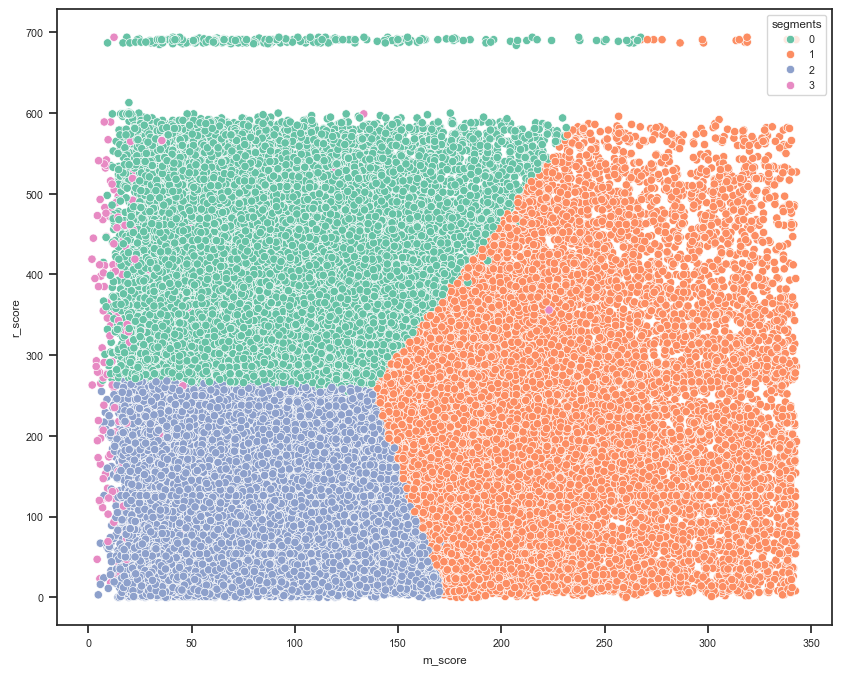

In [ ]:
x_axis = df_seg_kmeans['m_score']
y_axis = df_seg_kmeans['r_score']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['segments'],
                palette = 'Set2', legend = 'full')
plt.show()

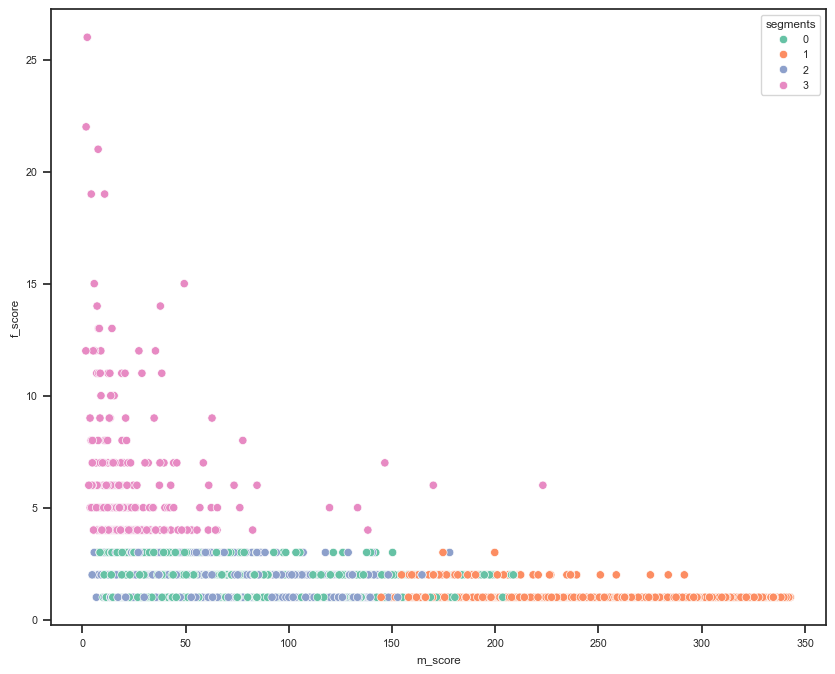

In [ ]:
x_axis = df_seg_kmeans['m_score']
y_axis = df_seg_kmeans['f_score']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['segments'],
                palette = 'Set2', legend = 'full')
plt.show()

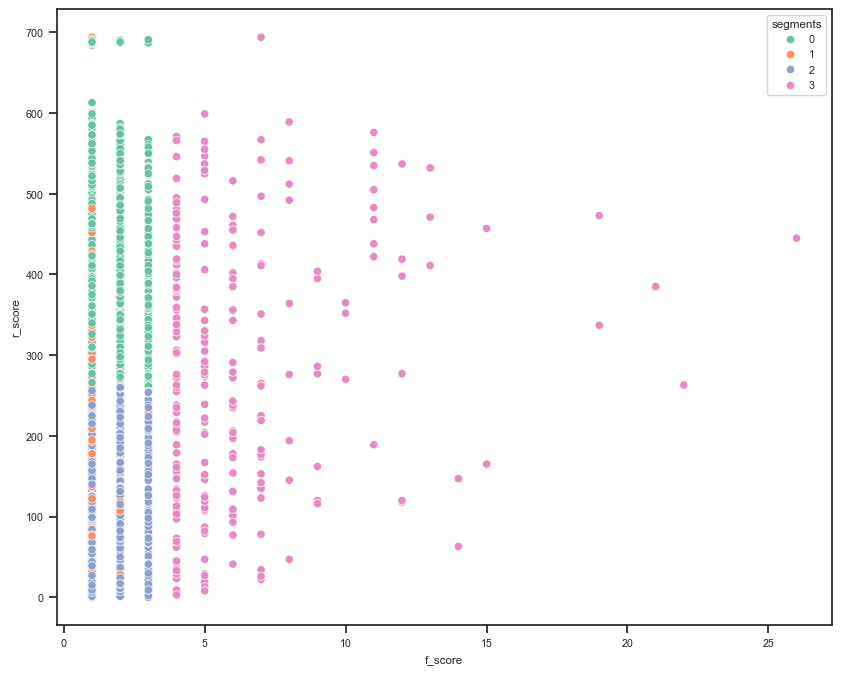

In [ ]:
x_axis = df_seg_kmeans['f_score']
y_axis = df_seg_kmeans['r_score']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['segments'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
df_analysis

r_score   f_score     m_score  #observations  Percentage
segments                                                             
0         399.444037  1.043698   85.286909          29475    0.331504
1         215.694132  1.004544  218.841439          20247    0.227717
2         128.349685  1.035762   79.212714          38924    0.437776
3         278.273408  6.142322   25.124169            267    0.003003

Before proceeding with further analysis, it is evident that Cluster 3 does not distinctly represent a cluster. Consequently, we will reduce the K-means clustering to three clusters and reassess the results

### __K means for 3 cluster__

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++',random_state = 1)
kmeans.fit(features_scaled)
df_seg_kmeans = df_rfm.copy()
df_seg_kmeans['segments'] = kmeans.labels_
df_seg_kmeans.head()

customer_id  r_score  f_score  m_score  segments
0  00012a2ce6f8dcda20d059ce98491703    287.0        1   114.74         0
1  000161a058600d5901f007fab4c27140    409.0        1    67.41         0
2  0001fd6190edaaf884bcaf3d49edf079    547.0        1   195.42         0
3  0002414f95344307404f0ace7a26f1d5    377.0        1   179.35         1
4  000379cdec625522490c315e70c7a9fb    147.0        1   107.01         2

In [ ]:
df_analysis = df_seg_kmeans.groupby('segments').agg({'r_score':'mean','f_score':'mean','m_score':'mean'})
df_analysis

r_score   f_score     m_score
segments                                  
0         399.708237  1.086281   84.335733
1         216.905798  1.003871  218.434771
2         128.679644  1.039102   79.214134

In [ ]:
df_analysis['#observations'] = df_seg_kmeans[['segments','f_score']].groupby(['segments']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis

r_score   f_score     m_score  #observations  Percentage
segments                                                             
0         399.708237  1.086281   84.335733          29404    0.330705
1         216.905798  1.003871  218.434771          20406    0.229505
2         128.679644  1.039102   79.214134          39103    0.439789

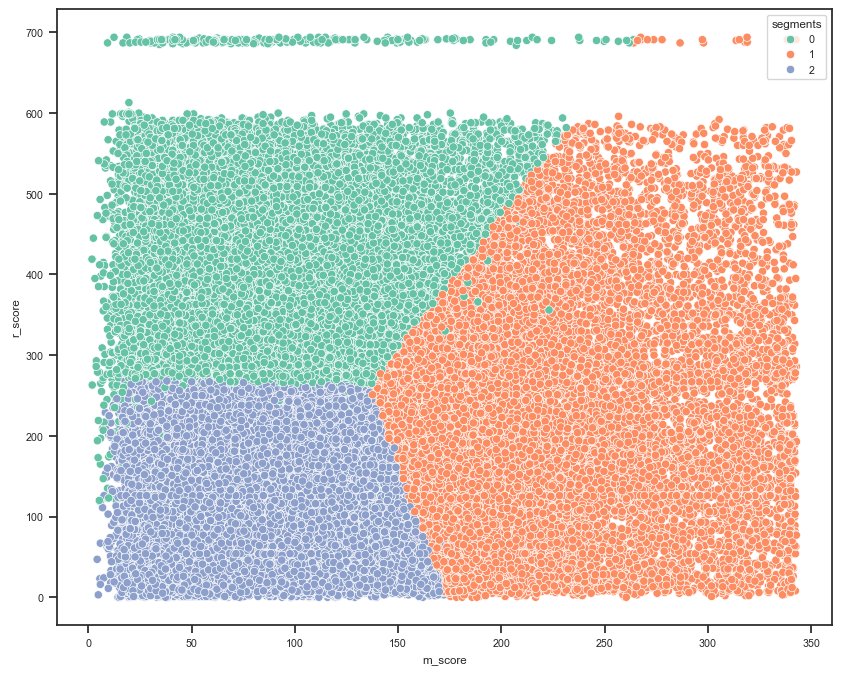

In [ ]:
x_axis = df_seg_kmeans['m_score']
y_axis = df_seg_kmeans['r_score']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['segments'],
                palette = 'Set2', legend = 'full')
plt.show()

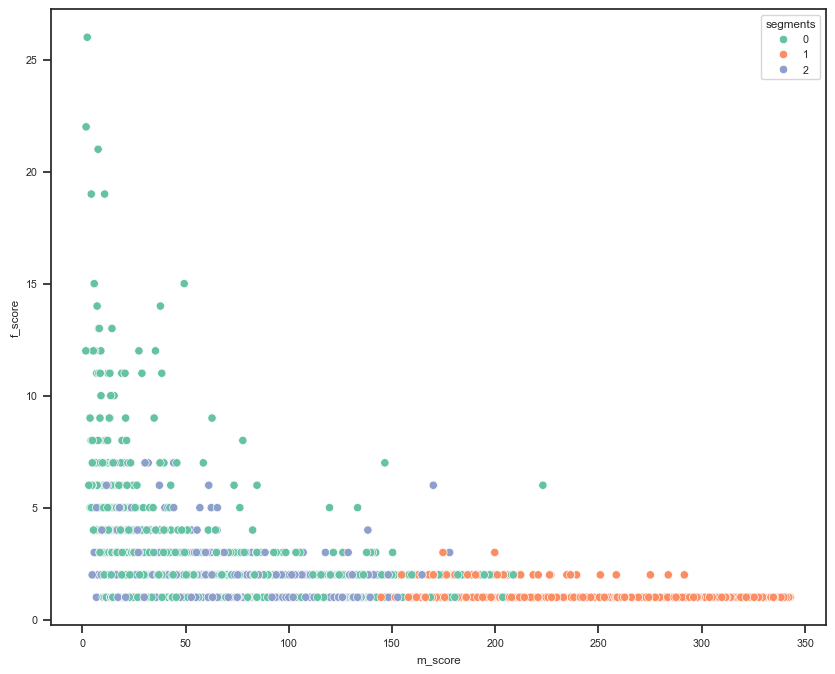

In [ ]:
x_axis = df_seg_kmeans['m_score']
y_axis = df_seg_kmeans['f_score']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['segments'],
                palette = 'Set2', legend = 'full')
plt.show()

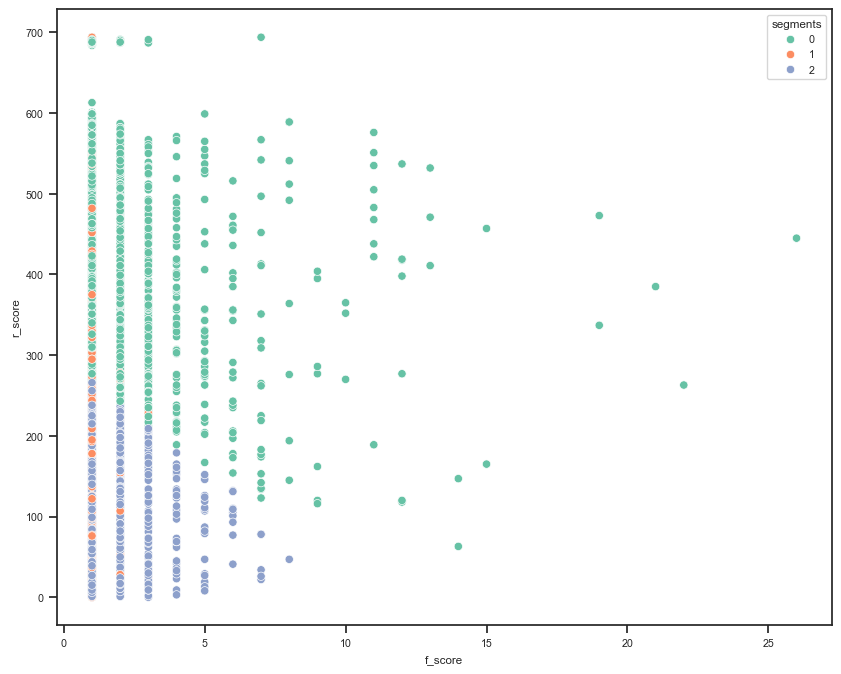

In [ ]:
x_axis = df_seg_kmeans['f_score']
y_axis = df_seg_kmeans['r_score']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_seg_kmeans['segments'],
                palette = 'Set2', legend = 'full')
plt.show()

## Insights and interpreations ##

This segementation show us 4 kinds of customers. Using these information is key to understand the situtation and do the following reccomandeation system.

-------------------------------------------------------
* __Frist group (segment 0):__ Customer hith high monetary
scores (m), here we see from people with high and low shopping frequency.


* __Second group (segment 1):__ Customer who had recent purchases.


* __Third group (segment 2):__ Customers who have been without shopping for a long time, also low expenders.
-------------------------------------------------------

# __Recommendation System__ #

## Item-Based Collaborative Filtering

__Description:__ Using a sparse matrix, this approach efficiently computes item-item similarity based on purchases, overcoming memory constraints of dense matrices. It recommends products similar to a given product, providing similarity scores as ratings, ideal for large, sparse datasets like Olist.

__Cons:__ While similarity is a major factor in order to the user to finde and compare a range of products it may not be as tailored as a user base recommendation system.

In [ ]:
recom_data = order_data.merge(order_item_data, on='order_id').merge(customer_data, on='customer_id')
recom_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2018-08-13 00:00:00              1   
2           2018-09-04 00:00:00              1   
3           2017-12-15 00:00:00              1   
4           2018-02-26 00:00:00              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

   shipping_limit_date   price  freight_value  \
0  2017-10-06 11:07:15   29.99           8.72   
1  2018-07-30 03:24:27  118.70          22.76   
2  2018-08-13 08:55:23  159.90          19.22   
3  2017-11-23 19:45:59   45.00          27.20   
4  2018-02-19 20:31:37   19.90           8.72   

                 customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149   
1  af07308b275d755c9edb36a90c618231                     47813   
2  3a653a41f6f9fc3d2a113cf8398680e8                     75265   
3  7c142cf63193a1473d2e66489a9ae977                     59296   
4  72632f0f9dd73dfee390c9b22eb56dd6                      9195   

             customer_city customer_state  
0                sao paulo             SP  
1                barreiras             BA  
2               vianopolis             GO  
3  sao goncalo do amarante             RN  
4              santo andre             SP

In [ ]:
# Prepare data for sparse matrix
# Group by customer and product to count purchases
interaction_data = recom_data.groupby(['customer_unique_id', 'product_id']).size().reset_index(name='count')

In [ ]:
# Map customer and product IDs to indices
customer_ids = interaction_data['customer_unique_id'].unique()
product_ids = interaction_data['product_id'].unique()
customer_map = {id: idx for idx, id in enumerate(customer_ids)}
product_map = {id: idx for idx, id in enumerate(product_ids)}

In [ ]:
# Create row and column indices
rows = interaction_data['customer_unique_id'].map(customer_map)
cols = interaction_data['product_id'].map(product_map)
values = interaction_data['count']

In [ ]:
# Create sparse user-item matrix
user_item_matrix = csr_matrix((values, (rows, cols)), shape=(len(customer_ids), len(product_ids)))

In [ ]:
# Compute item-item similarity
item_similarity = cosine_similarity(user_item_matrix.T)  # Transpose for item-based similarity

In [ ]:
# Convert to DataFrame for easier handling
item_similarity_df = pd.DataFrame(item_similarity, index=product_ids, columns=product_ids)

In [ ]:
# Function to recommend products with ratings
def recommend_products(product_id, num_recommendations=5):
    if product_id not in item_similarity_df.index:
        return "Product ID not found."
    # Get similarity scores and sort them
    similar_scores = item_similarity_df[product_id].sort_values(ascending=False)
    # Exclude the product itself (top score) and take top N
    recommendations = similar_scores.iloc[1:num_recommendations+1]
    # Return product IDs with their similarity scores
    return [(prod_id, score) for prod_id, score in recommendations.items()]

In [ ]:
# Example: Recommend products similar to a product_id
sample_product = recom_data['product_id'].sample(1).iloc[0]
recommended = recommend_products(sample_product, num_recommendations=5)
print('For Product ID:', sample_product)
for product_id, rating in recommended:
    print(f"Product: {product_id}, Rating: {rating:.3f}")

For Product ID: e9c1abcc7126360336d8f56d49041a8c
Product: 0c9439abe84dc40a64fc164365c4d064, Rating: 0.023
Product: 372645c7439f9661fbbacfd129aa92ec, Rating: 0.000
Product: 1d9ec694c5ecfc2d472cf83b1c4891c6, Rating: 0.000
Product: 19f1b5c58fd03aa8c41db25200829903, Rating: 0.000
Product: 8365b258a7ca21a31b8c972495efd2f7, Rating: 0.000


## Collaborative Filtering with Surprise (SVD) #1

This method, implemented with Surprise, applies Singular Value Decomposition to factorize the user-item matrix into latent dimensions. It predicts user preferences by reconstructing ratings from these latent factors.

In [ ]:
# Merge data to include review scores (assuming order_reviews_data exists)
recom_data = order_data.merge(order_item_data, on='order_id').merge(customer_data, on='customer_id')
recom_data = recom_data.merge(order_reviews_data[['order_id', 'review_score']], on='order_id', how='left')

In [ ]:
# Prepare data: Use review scores as ratings, default to 1 if no review
interactions = recom_data[['customer_unique_id', 'product_id', 'review_score']].drop_duplicates()
interactions['rating'] = interactions['review_score'].fillna(1)  # Default to 1 for missing reviews

In [ ]:
# Load into Surprise and define rating scale (1 to 5)
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(interactions[['customer_unique_id', 'product_id', 'rating']], reader)

In [ ]:
# Split into train and test sets
trainset, testset = train_test_split(dataset, test_size=0.2)

In [ ]:
# Train SVD model
model = SVD()
model.fit(trainset)

In [ ]:
# Test accuracy
predictions = model.test(testset)
print(f"RMSE: {accuracy.rmse(predictions)}")

RMSE: 1.2837
RMSE: 1.2837304243999161


In [ ]:
# Updated recommend function for a specific customer
def recommend_for_user(customer_id, num_recommendations=5):
    all_products = recom_data['product_id'].unique()
    purchased = recom_data[recom_data['customer_unique_id'] == customer_id]['product_id'].unique()
    not_purchased = [p for p in all_products if p not in purchased]
    predictions = [model.predict(customer_id, prod) for prod in not_purchased]
    return sorted(predictions, key=lambda x: x.est, reverse=True)[:num_recommendations]

In [ ]:
# Example
recommendations = recommend_for_user(recom_data['customer_unique_id'].sample(1).iloc[0], num_recommendations=5)
print("Product Recommendations:")
for pred in recommendations:
    print(f"Product: {pred.iid}, Predicted Score: {pred.est}")

Product Recommendations:
Product: 73326828aa5efe1ba096223de496f596, Predicted Score: 4.780377112612832
Product: 6a8631b72a2f8729b91514db87e771c0, Predicted Score: 4.731158087849609
Product: ad2037645597db38527fe3afbe226af2, Predicted Score: 4.723770477062971
Product: 3e4176d545618ed02f382a3057de32b4, Predicted Score: 4.7001349739876375
Product: f7f59e6186e10983a061ac7bdb3494d6, Predicted Score: 4.693600008210568


## Collaborative Filtering with Surprise (SVD) #2

An extension of SVD via Surprise, this approach incorporates user and item biases into the factorization process. It enhances recommendation accuracy by adjusting for systematic rating tendencies.

In [ ]:
# Convert zip codes to object type
customer_data['customer_zip_code_prefix'] = customer_data['customer_zip_code_prefix'].astype(object)
seller_data['seller_zip_code_prefix'] = seller_data['seller_zip_code_prefix'].astype(object)

In [ ]:
# --- Data Preparation for Collaborative Filtering ---
# Merge orders with order items and customers to get user-item interactions
user_item_data = order_data.merge(order_item_data, on='order_id').merge(customer_data, on='customer_id')
user_item_data = user_item_data[['customer_unique_id', 'product_id', 'order_id']]

# Merge with reviews to include ratings (if available)
user_item_data = user_item_data.merge(order_reviews_data[['order_id', 'review_score']], on='order_id', how='left')

# If no review score exists, assume a binary interaction (1 for purchase)
user_item_data['rating'] = user_item_data['review_score'].fillna(1)

# Keep only relevant columns
user_item_data = user_item_data[['customer_unique_id', 'product_id', 'rating']]

# Remove duplicates (in case a customer bought the same product multiple times)
user_item_data = user_item_data.drop_duplicates()

print("======== User-Item Interaction Data ========")
print(user_item_data.head())
print(user_item_data.info())

======== User-Item Interaction Data ========
                 customer_unique_id                        product_id  rating
0  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a       4
1  af07308b275d755c9edb36a90c618231  595fac2a385ac33a80bd5114aec74eb8       4
2  3a653a41f6f9fc3d2a113cf8398680e8  aa4383b373c6aca5d8797843e5594415       5
3  7c142cf63193a1473d2e66489a9ae977  d0b61bfb1de832b15ba9d266ca96e5b0       5
4  72632f0f9dd73dfee390c9b22eb56dd6  65266b2da20d04dbe00c5c2d3bb7859e       5
<class 'pandas.core.frame.DataFrame'>
Index: 102366 entries, 0 to 113321
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   customer_unique_id  102366 non-null  object
 1   product_id          102366 non-null  object
 2   rating              102366 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB
None


Collaborative Filtering with Surprise

In [ ]:

# Define the rating scale (e.g., 1-5 for review scores, or 1 for binary)
reader = Reader(rating_scale=(1,5))

In [ ]:
# Load data into Surprise format
data = Dataset.load_from_df(user_item_data[['customer_unique_id', 'product_id', 'rating']], reader)

In [ ]:
# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

In [ ]:
# Use SVD for matrix factorization
algo = SVD()

In [ ]:
# Train the model
algo.fit(trainset)

In [ ]:
# Test the model
predictions = algo.test(testset)

In [ ]:
# Evaluate the model
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3331  1.3449  1.3444  1.3417  1.3377  1.3404  0.0044  
MAE (testset)     1.0543  1.0653  1.0629  1.0628  1.0605  1.0611  0.0037  
Fit time          1.79    1.89    1.81    1.70    1.98    1.84    0.10    
Test time         0.11    0.11    0.11    0.11    0.13    0.11    0.01    


{'test_rmse': array([1.33309367, 1.34489162, 1.3444164 , 1.34173007, 1.33765991]),
 'test_mae': array([1.05431918, 1.06525021, 1.06288223, 1.06283984, 1.06045815]),
 'fit_time': (1.7947871685028076,
  1.8919429779052734,
  1.8093032836914062,
  1.7004890441894531,
  1.98236083984375),
 'test_time': (0.10570573806762695,
  0.11293268203735352,
  0.11477923393249512,
  0.11187410354614258,
  0.125152587890625)}

In [ ]:
# --- Generate Recommendations ---
def get_top_n_recommendations(user_id, n=5):
    # Get all products the user hasn’t interacted with
    all_products = user_item_data['product_id'].unique()
    user_products = user_item_data[user_item_data['customer_unique_id'] == user_id]['product_id'].unique()
    products_to_predict = [prod for prod in all_products if prod not in user_products]

    # Predict ratings for these products
    predictions = [algo.predict(user_id, prod) for prod in products_to_predict]

    # Sort by predicted rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Return top N
    top_n = predictions[:n]
    return [(pred.iid, pred.est) for pred in top_n]

In [ ]:
# Example: Get recommendations for a specific user
sample_user = user_item_data.sample(1)['customer_unique_id'].iloc[0]
recommendations = get_top_n_recommendations(sample_user, n=5)
print(f"\nTop 5 recommendations for user {sample_user}:")
for product_id, score in recommendations:
    print(f"Product ID: {product_id}, Predicted Rating: {score:.2f}")


Top 5 recommendations for user d0be859f85cda9d896ab14e4ffba955d:
Product ID: e0cf79767c5b016251fe139915c59a26, Predicted Rating: 5.00
Product ID: ba9f160a6ae1c23f25d690fd06fe4fd8, Predicted Rating: 4.86
Product ID: 3e4176d545618ed02f382a3057de32b4, Predicted Rating: 4.84
Product ID: d918b3f4aa5272c2c3cd088d087ca069, Predicted Rating: 4.83
Product ID: 38c56c5c5b16958d95bf8254498ad555, Predicted Rating: 4.82


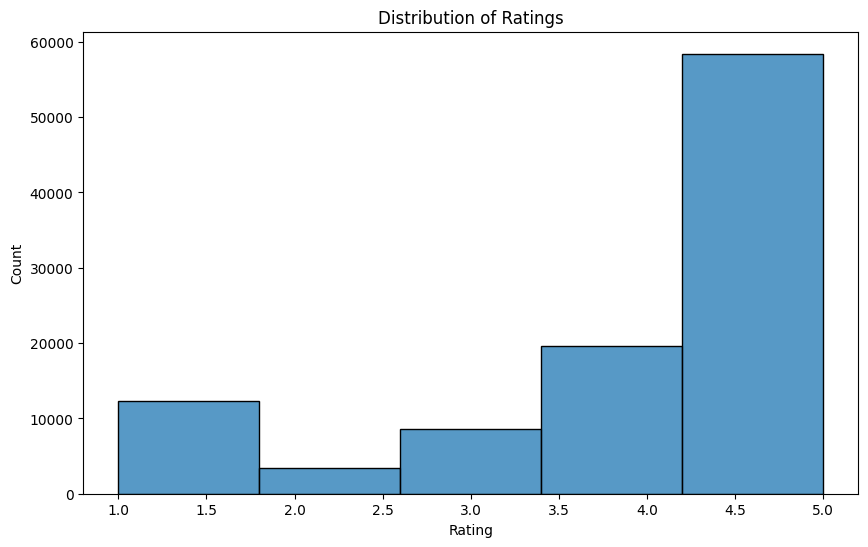

In [ ]:
# --- Optional: Visualize User-Item Interactions ---
plt.figure(figsize=(10, 6))
sns.histplot(user_item_data['rating'], bins=5, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# __Evaluation__

## Item-Based Collaborative Filtering

In [ ]:
test_data = user_item_data.sample(frac=0.2, random_state=42)
train_data = user_item_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data.head(), '\n'

(                 customer_unique_id                        product_id  rating
 0  7c396fd4830fd04220f754e42b4e5bff  87285b34884572647811a353c7ac498a       4
 1  af07308b275d755c9edb36a90c618231  595fac2a385ac33a80bd5114aec74eb8       4
 2  3a653a41f6f9fc3d2a113cf8398680e8  aa4383b373c6aca5d8797843e5594415       5
 3  7c142cf63193a1473d2e66489a9ae977  d0b61bfb1de832b15ba9d266ca96e5b0       5
 4  72632f0f9dd73dfee390c9b22eb56dd6  65266b2da20d04dbe00c5c2d3bb7859e       5,
 '\n')

In [ ]:
#Assume test_data is a DataFrame with ['customer_unique_id', 'product_id', 'actual'] (1 or 0)
def evaluate_item_based(test_data, num_recommendations=5):
    y_true = []
    y_scores = []
    for customer_id in test_data['customer_unique_id'].unique():
        purchased = test_data[test_data['customer_unique_id'] == customer_id]['product_id'].values
        if len(purchased) < 1:
            continue
        sample_product = purchased[0]  # Take one purchased product
        recommendations = recommend_products(sample_product, num_recommendations)
        recommended_ids = [prod_id for prod_id, _ in recommendations]
        scores = [score for _, score in recommendations]

        # Ground truth: 1 if recommended product was purchased, 0 otherwise
        actual = [1 if prod in purchased else 0 for prod in recommended_ids]
        y_true.extend(actual)
        y_scores.extend(scores[:len(actual)])  # Match lengths

    auc_ItemBased = roc_auc_score(y_true, y_scores)
    precision1__ItemBased = precision_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])
    recall__ItemBased = recall_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])
    f1__ItemBased = f1_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])
    return auc_ItemBased, precision1__ItemBased, recall__ItemBased, f1__ItemBased

In [ ]:
print('Item-Based Collaborative Filtering Evaluation Metrics:')
auc_ItemBased, precision1__ItemBased, recall__ItemBased, f1__ItemBased = evaluate_item_based(test_data)
print(f'AUC: {auc_ItemBased:.4f}')
print(f'Precision: {precision1__ItemBased:.4f}')
print(f'Recall: {recall__ItemBased:.4f}')
print(f'F1 Score: {f1__ItemBased:.4f}')

Item-Based Collaborative Filtering Evaluation Metrics:
AUC: 0.9546
Precision: 0.1742
Recall: 0.5222
F1 Score: 0.2612


## Collaborative Filtering with Surprise (SVD #1)

In [ ]:
# Existing predictions from testset
predictions = model.test(testset)

In [ ]:
# Binarize ratings: >=3 is positive (relevant), else negative
y_true = [1 if pred.r_ui >= 3 else 0 for pred in predictions]
y_scores = [pred.est for pred in predictions]

In [ ]:
# Compute metrics
auc_SVD_1 = roc_auc_score(y_true, y_scores)
precision_SVD_1 = precision_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])
recall_SVD_1 = recall_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])
f1_SVD_1 = f1_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])

In [ ]:
print(f"AUC: {auc_SVD_1:.3f}")
print(f"Precision: {precision_SVD_1:.3f}")
print(f"Recall: {recall_SVD_1:.3f}")
print(f"F1-Score: {f1_SVD_1:.3f}")
print(f"RMSE: {accuracy.rmse(predictions)}")

AUC: 0.771
Precision: 0.849
Recall: 1.000
F1-Score: 0.918
RMSE: 1.2837
RMSE: 1.2837304243999161


## Collaborative Filtering with Surprise (SVD #2)

In [ ]:
# Existing predictions from testset
predictions = algo.test(testset)

In [ ]:
# Binarize ratings: >=3 is positive (relevant), else negative
y_true = [1 if pred.r_ui >= 3 else 0 for pred in predictions]
y_scores = [pred.est for pred in predictions]

In [ ]:
# Compute metrics
auc_SVD_2 = roc_auc_score(y_true, y_scores)
precision_SVD_2 = precision_score(y_true, [1 if s >= 3 else 0 for s in y_scores])
recall_SVD_2 = recall_score(y_true, [1 if s >= 3 else 0 for s in y_scores])
f1_SVD_2 = f1_score(y_true, [1 if s >= 3 else 0 for s in y_scores])

In [ ]:
print(f"AUC: {auc_SVD_2:.3f}")
print(f"Precision: {precision_SVD_2:.3f}")
print(f"Recall: {recall_SVD_2:.3f}")
print(f"F1-Score: {f1_SVD_2:.3f}")

AUC: 0.942
Precision: 0.895
Recall: 0.998
F1-Score: 0.943


## Visual representation

In [ ]:
# Placeholder metric values (replace these with your actual results)
metrics = {
    'System': ['Item-Based CF', 'SVD #1', 'SVD #2'],
    'AUC': [auc_ItemBased, auc_SVD_1, auc_SVD_2],
    'Precision': [precision1__ItemBased, precision_SVD_1, precision_SVD_2],
    'Recall': [recall__ItemBased, recall_SVD_1, recall_SVD_2],
    'F1 Score': [f1__ItemBased, f1_SVD_1, f1_SVD_2],
}
# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df.head()

System       AUC  Precision    Recall  F1 Score
0  Item-Based CF  0.954588   0.174199  0.522167  0.261245
1   SVD #1 (1-5)  0.770877   0.848540  1.000000  0.918065
2         SVD #2  0.941532   0.894878  0.997640  0.943469

In [ ]:
# Melt the DataFrame for seaborn
metrics_melted = metrics_df.melt(id_vars=['System'],
                                 value_vars=['AUC', 'Precision', 'Recall', 'F1 Score'],
                                 var_name='Metric',
                                 value_name='Score')

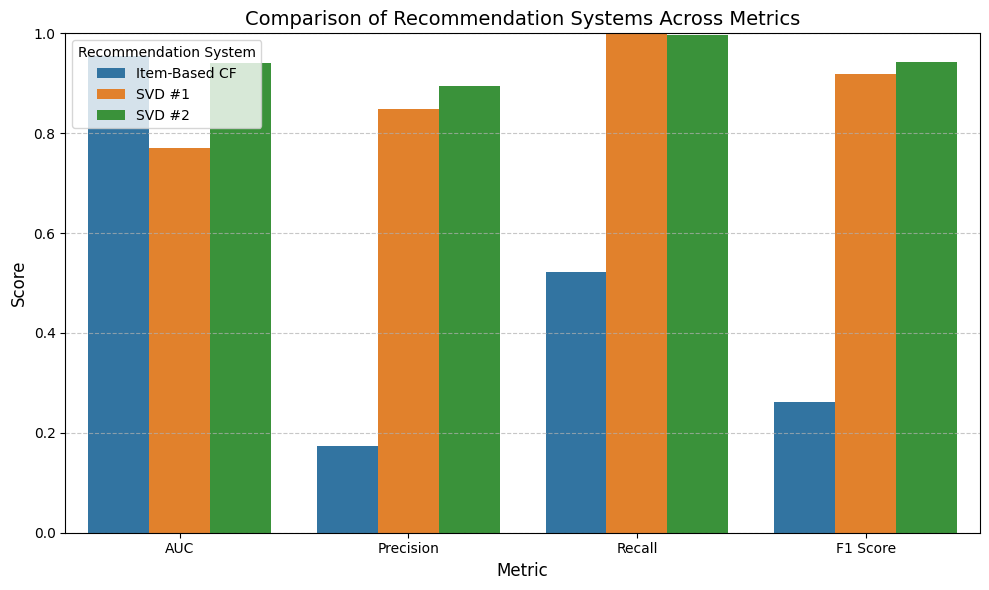

In [ ]:
# Create the bar plot using the melted DataFrame
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='System', data=metrics_melted)  # Use metrics_melted here

# Customize the plot
plt.title('Comparison of Recommendation Systems Across Metrics', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.legend(title='Recommendation System', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Insights

### __1. AUC (Area Under the ROC Curve)__

- Item-Based CF (0.954588): Best at ranking relevant items highest.
    - Great for ordered lists, like “Top Products.”
    - Outshines SVD in ranking ability.
- SVD #1 (0.770877): Weakest ranking performance.
    - Struggles to prioritize relevant items.
    - Lags far behind others in AUC.
- SVD #2 (0.941532): Strong ranking, near Item-Based CF.
    - Effectively orders relevant items.
    - Close second in AUC.

### __2. Precision__

- Item-Based CF (0.174199): Very low, only 17.4% relevant.
    - Most recommendations miss the mark.
    - Poor accuracy in suggestions.
- SVD #1 (0.848540): High, 84.9% relevant recommendations.
    - Avoids irrelevant suggestions well.
    - Solid accuracy.
- SVD #2 (0.894878): Highest, 89.5% relevant.
    - Most accurate recommendations.
    - Slightly beats SVD #1.

### __3. Recall__

- Item-Based CF (0.522167): Moderate, captures 52.2%.
    - Misses nearly half of relevant items.
    - Limited coverage.
- SVD #1 (1.000000): Perfect, 100% relevant items caught.
    - Exhaustive coverage of preferences.
    - No misses.
- SVD #2 (0.997640): Near-perfect, 99.8% coverage.
    - Catches almost all relevant items.
    - Tiny miss rate.

### __4. F1-Score__

- Item-Based CF (0.261245): Low, poor balance at 26.1%.
    - Weak precision drags it down.
    - Not well-rounded.
- SVD #1 (0.918065): High, 91.8% balance.
    - Strong precision and perfect recall.
    - Very effective.
- SVD #2 (0.943469): Top, 94.3% balance.
    - Best mix of precision and recall.
    - Most reliable.

### __Overall Comparison__

- __Item-Based CF:__ Great ranking (AUC), terrible precision and F1.
Best for non-personalized ranking tasks.
Weak for user-specific recommendations.

- __SVD #1:__ Perfect recall, good precision, weak AUC.
Excellent coverage, less focus on ranking.
Suits discovery over ranked lists.

- __SVD #2:__ Near-perfect across all metrics.
Balances ranking and recommendation quality.
Ideal for personalized suggestions.

# __Sentiment Analysis__

In the following sentiment analysis, all review comments will be inspected and analyzed to determine their meaning. Using the **LeIA** library, which enables the separation of positive and negative words in Portuguese, we will evaluate these comments to assess their sentiment.

## Data preparation

In [ ]:
# Merging Dataframes
df = order_data.merge(order_item_data, on='order_id', how='inner')
df = df.merge(order_payments_data, on='order_id', how='inner', validate='m:m')
df = df.merge(order_reviews_data, on='order_id', how='inner')
df = df.merge(product_data, on='product_id', how='inner')
df = df.merge(customer_data, on='customer_id', how='inner')
df = df.merge(seller_data, on='seller_id', how='inner')
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  delivery_time purchase_day_of_week  ...  \
0                    2017-10-18            2.0               Monday  ...   
1                    2017-10-18            2.0               Monday  ...   
2                    2017-10-18            2.0               Monday  ...   
3                    2018-08-13            1.0              Tuesday  ...   
4                    2018-09-04            0.0            Wednesday  ...   

   product_category_name_english_y product_category_name_english    category  \
0                       housewares                    housewares  housewares   
1                       housewares                    housewares  housewares   
2                       housewares                    housewares  housewares   
3                        perfumery                     perfumery   perfumery   
4                             auto                          auto        auto   

                 customer_unique_id customer_zip_code_prefix  customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                     3149      sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                     3149      sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                     3149      sao paulo   
3  af07308b275d755c9edb36a90c618231                    47813      barreiras   
4  3a653a41f6f9fc3d2a113cf8398680e8                    75265     vianopolis   

   customer_state  seller_zip_code_prefix     seller_city  seller_state  
0              SP                    9350            maua            SP  
1              SP                    9350            maua            SP  
2              SP                    9350            maua            SP  
3              BA                   31570  belo horizonte            SP  
4              GO                   14840         guariba            SP  

[5 rows x 47 columns]

In [ ]:
# Ensure timestamps are in datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create useful features from order_purchase_timestamp
df['day_of_week_int'] = df['order_purchase_timestamp'].dt.weekday + 1  # Day of week as integer (1 = Monday, etc.)
df['hour'] = df['order_purchase_timestamp'].dt.hour                    # Hour of day
df['month'] = df['order_purchase_timestamp'].dt.month                  # Month as integer
df['year'] = df['order_purchase_timestamp'].dt.year                    # Year as integer
df['date'] = df['order_purchase_timestamp'].dt.to_period('M')          # Monthly period for time series analysis

# Calculate delivery time in days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [ ]:
# Renaming the column to correct the spelling
df.rename(columns={'product_name_lenght': 'product_name_length'}, inplace=True)

In [ ]:
# Selecting only necessary columns for NLP analysis
nlp_df = df[['review_comment_title', 'review_comment_message', 'product_category_name']]

In [ ]:
nlp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118315 entries, 0 to 118314
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_comment_title    14089 non-null   object
 1   review_comment_message  50654 non-null   object
 2   product_category_name   116606 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


We need those objects to text

In [ ]:
print("There are {} product categories in the dataset.".format(nlp_df.product_category_name.nunique()))

There are 73 product categories in the dataset.


## Data cleaning

In [ ]:
# Calculating the total number of NaN values in each column of the DataFrame 'nlp_df'
nan_counts = nlp_df.isna().sum()
nan_counts

review_comment_title      104226
review_comment_message     67661
product_category_name       1709
dtype: int64

In [ ]:
# Calculating the total number of NaN values in the 'review_comment_message' column of 'nlp_df'
nan_count_review_comment_message = nlp_df['review_comment_message'].isna().sum()
nan_count_review_comment_message

67661

In [ ]:
def remove_duplicates_nlp_df(nlp_df, column_name='review_comment_message'):

    # Remove duplicates based on the specified column, keeping the first occurrence
    nlp_df = nlp_df.drop_duplicates(subset=[column_name], keep='first').reset_index(drop=True)

    # Display the total entries after removing duplicates
    print(f"Total entries after removing duplicates in '{column_name}': {nlp_df.shape[0]}")

    return nlp_df

# Remove duplicates from 'nlp_df' based on the 'review_comment_message' column
nlp_df = remove_duplicates_nlp_df(nlp_df, 'review_comment_message')

# Display the first few records to verify
nlp_df.head()

Total entries after removing duplicates in 'review_comment_message': 35565


review_comment_title                             review_comment_message  \
0                  NaN  I haven't tested the product yet, but it arriv...   
1     Muito boa a loja                          The product is very good.   
2                  NaN                                                NaN   
3                  NaN  The product was exactly what I expected and wa...   
4                  NaN               I was sad that you didn't answer me.   

   product_category_name  
0  utilidades_domesticas  
1             perfumaria  
2             automotivo  
3               pet_shop  
4                    NaN

In [ ]:
def clean_reviews(df):

    # Remove rows where 'review_comment_message' is empty
    df = df.dropna(subset=['review_comment_message', 'review_comment_title', 'product_category_name']).reset_index(drop=True)

    # Remove duplicate rows
    df = df.drop_duplicates(subset=['review_comment_message'])

    return df

# Assuming 'nlp_df' is your dataframe
df_cleaned = clean_reviews(nlp_df)

# Display the first records to check
df_cleaned.head()

review_comment_title                             review_comment_message  \
0     Muito boa a loja                          The product is very good.   
1             Nota dez  Thank you for your attention. Lannister stores...   
2              Ãtimo    I will always buy here because it is the best...   
3  NÃO RECOMENDO!!!!   So far I have not received the product Mattres...   
4          Enganadores  A different product was delivered than what I ...   

  product_category_name  
0            perfumaria  
1            perfumaria  
2             papelaria  
3                 bebes  
4          climatizacao

## Text processing

In [ ]:
# Define Portuguese stopwords
STOP_WORDS = set(stopwords.words('portuguese'))

In [ ]:
# Helper function to clean and tokenize text
def clean_and_tokenize(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        return "", []

    # Convert to lowercase, remove punctuation, and split into words
    cleaned_text = text.lower().translate(str.maketrans('', '', string.punctuation))
    words = cleaned_text.split()

    # Remove stopwords and create tokens
    filtered_words = [word for word in words if word not in STOP_WORDS]
    return " ".join(filtered_words), filtered_words

In [ ]:
# Main function to preprocess and clean the dataframe
def preprocess_nlp_df(df):
    # Clean, remove stopwords, and tokenize comments
    df[['review_comment_message_clean', 'review_comment_message_tokens']] = df['review_comment_message'].apply(
        lambda text: pd.Series(clean_and_tokenize(text))
    )

    # Remove rows with NaN values in key columns
    df.dropna(subset=['review_comment_title', 'review_comment_message'], inplace=True)

    # Drop duplicate rows based on the 'review_comment_message' and 'review_comment_title' columns
    df.drop_duplicates(subset=['review_comment_message', 'review_comment_title'], inplace=True)

    return df.reset_index(drop=True)

In [ ]:
# Preprocess the dataset
nlp_df = preprocess_nlp_df(nlp_df)

In [ ]:
# Display the first records to check
nlp_df[['review_comment_message', 'review_comment_message_clean', 'review_comment_message_tokens']].head()

review_comment_message  \
0                          The product is very good.   
1  Thank you for your attention. Lannister stores...   
2   I will always buy here because it is the best...   
3  So far I have not received the product Mattres...   
4  A different product was delivered than what I ...   

                        review_comment_message_clean  \
0                           the product is very good   
1  thank you your attention lannister stores perf...   
2  i will always buy here because it is the best ...   
3  so far i have not received the product mattres...   
4  different product was delivered than what i ha...   

                       review_comment_message_tokens  
0                     [the, product, is, very, good]  
1  [thank, you, your, attention, lannister, store...  
2  [i, will, always, buy, here, because, it, is, ...  
3  [so, far, i, have, not, received, the, product...  
4  [different, product, was, delivered, than, wha...

## Sentiment Analysis with LeIA

In [ ]:
# Initialize the Sentiment Analyzer once
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def classify_sentiment(df, column_name='review_comment_message_clean'):
    # Vectorized function to get sentiment classification
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    # Apply sentiment analysis using map for faster iteration
    df[f'{column_name}_sentiment'] = df[column_name].map(get_sentiment_classification)
    return df

In [ ]:
# Classify sentiment in 'nlp_df' based on the 'review_comment_message_clean' column
nlp_df = classify_sentiment(nlp_df, 'review_comment_message_clean')

In [ ]:
# Display the sentiment results
nlp_df[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(25)

review_comment_message_clean  \
0                            the product is very good   
1   thank you your attention lannister stores perf...   
2   i will always buy here because it is the best ...   
3   so far i have not received the product mattres...   
4   different product was delivered than what i ha...   
5               product came well sealed all original   
6   excellent delivery time and carefully packaged...   
7   received only 1 requested unit there should be...   
8            delivery before the scheduled date great   
9   only the seanite black travel bag 12771 was de...   
10  i sent email requesting support to make the pr...   
11  the product came in perfect condition and arri...   
12  the other products the store offered but did n...   
13  everything agreed delivery before the deadline...   
14                 received 22 days ahead of schedule   
15  very beautiful product arrived on time looks l...   
16  arrived ahead of schedule and the product orde...   
17  i liked the product but i was worried that it ...   
18                       received before the deadline   
19                                          very good   
20  i hope its always like this fast and perfect p...   
21  all services are great but i only found the cl...   
22        product does not correspond to expectations   
23                          i received an old product   
24  my opinion is that if i bought the product it ...   

   review_comment_message_clean_sentiment  
0                                 Neutral  
1                                 Neutral  
2                                 Neutral  
3                                 Neutral  
4                                 Neutral  
5                                Positive  
6                                 Neutral  
7                                 Neutral  
8                                 Neutral  
9                                 Neutral  
10                                Neutral  
11                                Neutral  
12                                Neutral  
13                                Neutral  
14                                Neutral  
15                                Neutral  
16                                Neutral  
17                                Neutral  
18                                Neutral  
19                                Neutral  
20                                Neutral  
21                                Neutral  
22                                Neutral  
23                                Neutral  
24                                Neutral

In [ ]:
# Concatenate all non-null texts from the 'cleaned_text' column into a single string
text_combined = " ".join(nlp_df['review_comment_message_clean'].dropna())

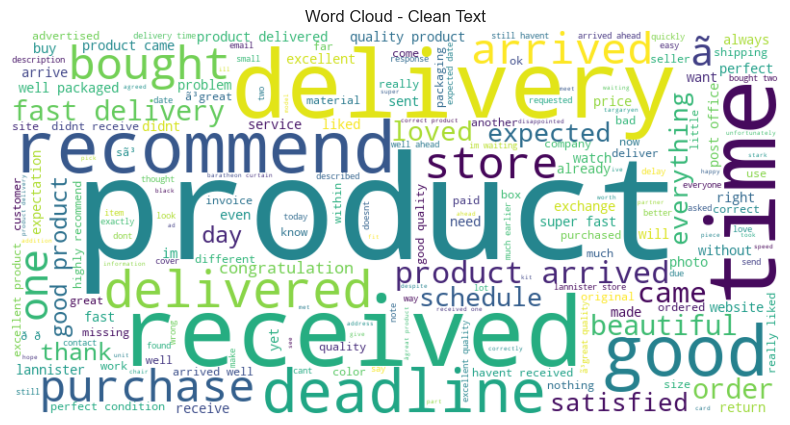

In [ ]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Clean Text")
plt.axis("off")
plt.show()

In [ ]:
def plot_word_clouds_by_sentiment(df, text_column='review_comment_message_clean', sentiment_column='review_comment_message_clean_sentiment'):
    # Filter text by sentiment
    sentiments = ['Positive', 'Neutral', 'Negative']

    for sentiment in sentiments:
        # Filter data by current sentiment
        text_data = " ".join(df[df[sentiment_column] == sentiment][text_column].dropna())

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment} Sentiment')
        plt.show()

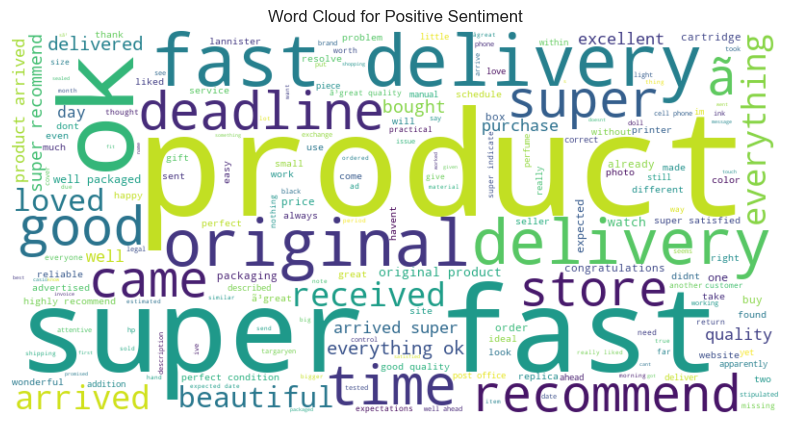

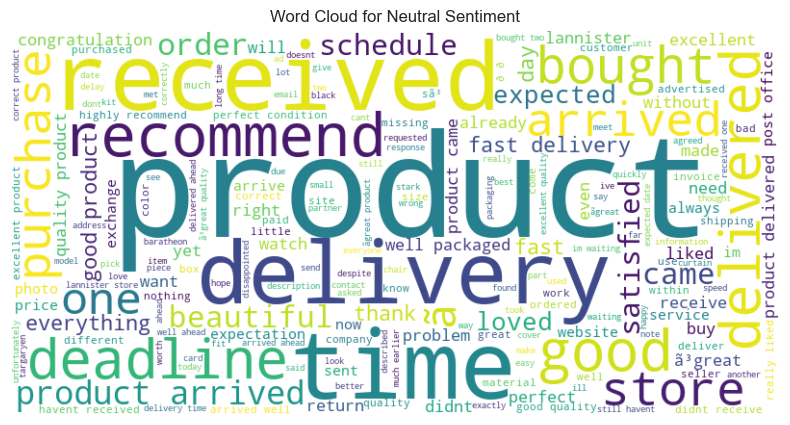

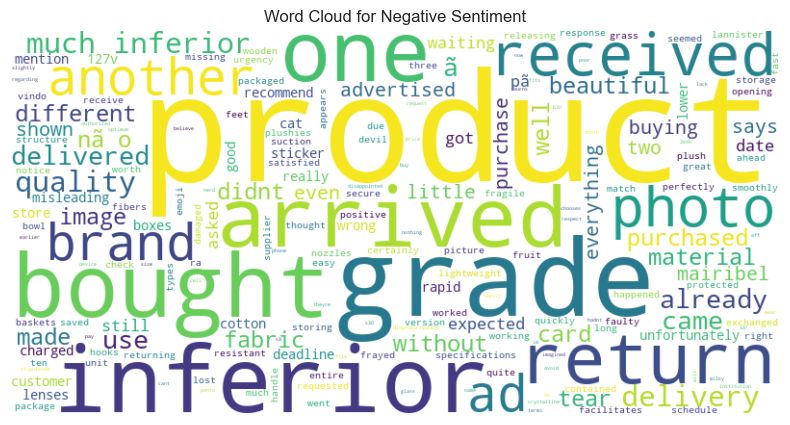

In [ ]:
# Generate word clouds based on sentiment for the specified columns
plot_word_clouds_by_sentiment(nlp_df, 'review_comment_message_clean', 'review_comment_message_clean_sentiment')

In [ ]:
def plot_token_count_distribution(df, token_column='review_comment_message_tokens'):
    # Calculate the number of tokens for each entry
    df['token_count'] = df[token_column].apply(len)

    # Plot the distribution of token counts
    plt.figure(figsize=(10, 6))
    plt.hist(df['token_count'], bins=30, edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Count in Comments')
    plt.show()

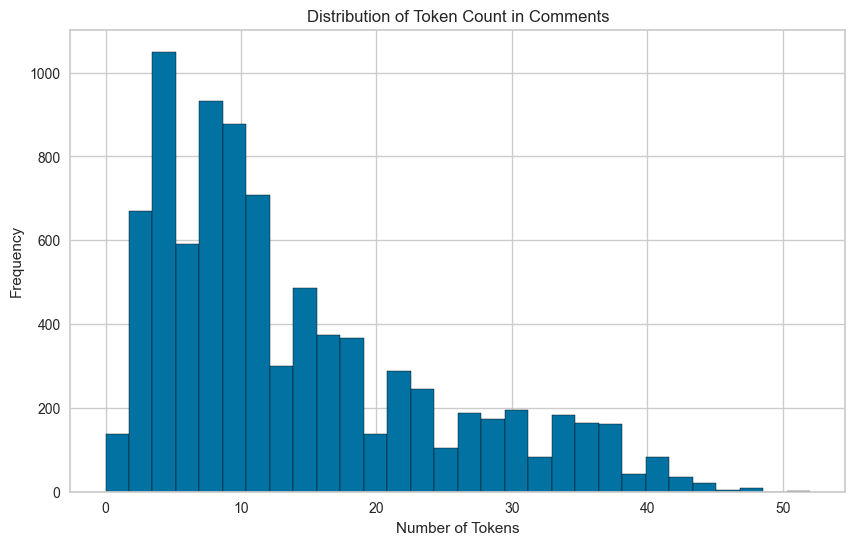

In [ ]:
# Generate the token count distribution plot
plot_token_count_distribution(nlp_df, 'review_comment_message_tokens')

In [ ]:
# Function to get top N tokens or n-grams
def get_top_tokens(df, token_column='review_comment_message_tokens', top_n=50):
    all_tokens = [token for tokens in df[token_column] for token in tokens]
    token_counts = Counter(all_tokens)
    return token_counts.most_common(top_n)

In [ ]:
# Function to create a DataFrame from frequency counts
def create_frequency_df(counter, columns=['Word', 'Frequency']):
    return pd.DataFrame(counter.items(), columns=columns)

In [ ]:
# General plotting function for bar charts
def plot_top_frequencies(df, title, xlabel, column_name):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(df[column_name], df['Frequency'])

    # Add labels
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() - max(5, bar.get_height() * 0.35),
                 f'{int(bar.get_height())}', ha='center', color='black', fontsize=10)

    # Customize and show plot
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

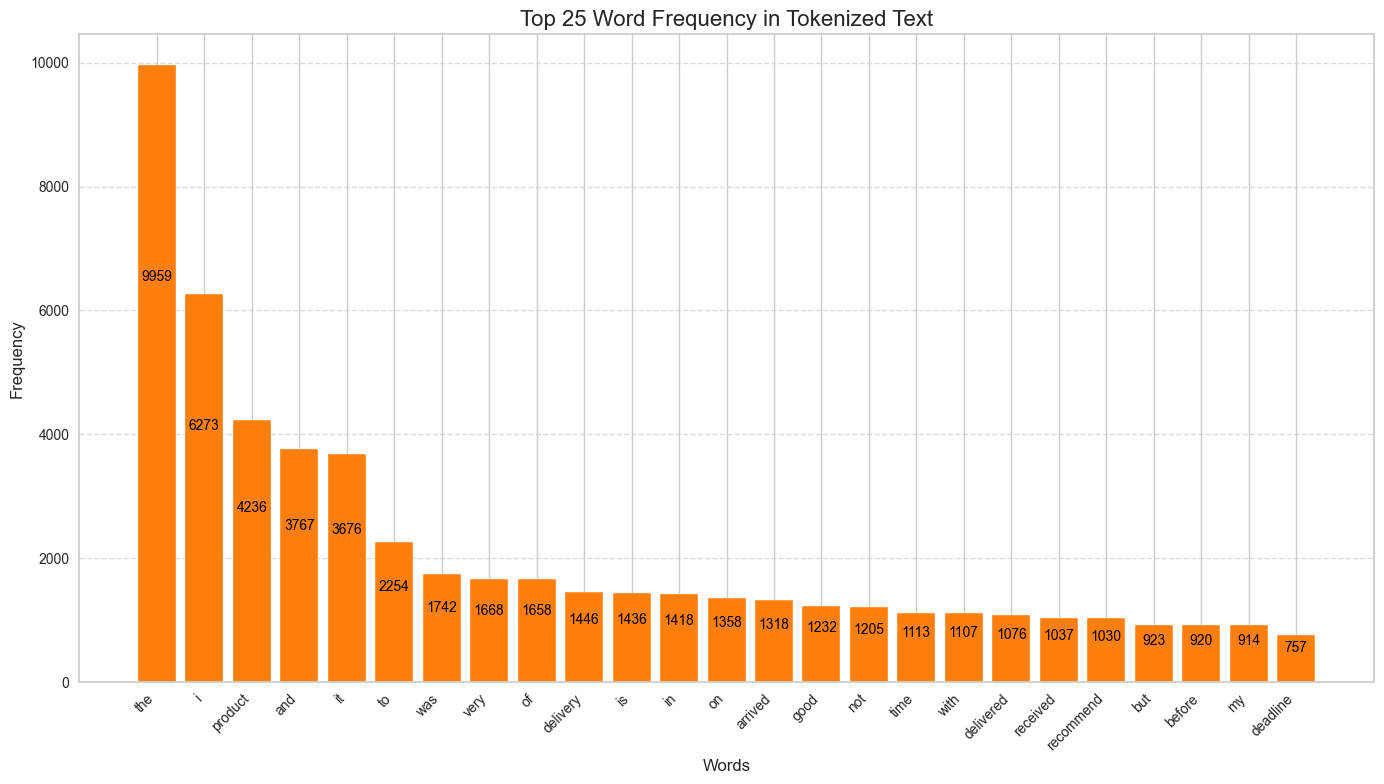

In [ ]:
# Get top tokens and plot
top_50_tokens = get_top_tokens(nlp_df, 'review_comment_message_tokens', 50)
top_50_tokens_df = create_frequency_df(dict(top_50_tokens))
plot_top_frequencies(top_50_tokens_df.head(25), 'Top 25 Word Frequency in Tokenized Text', 'Words', 'Word')

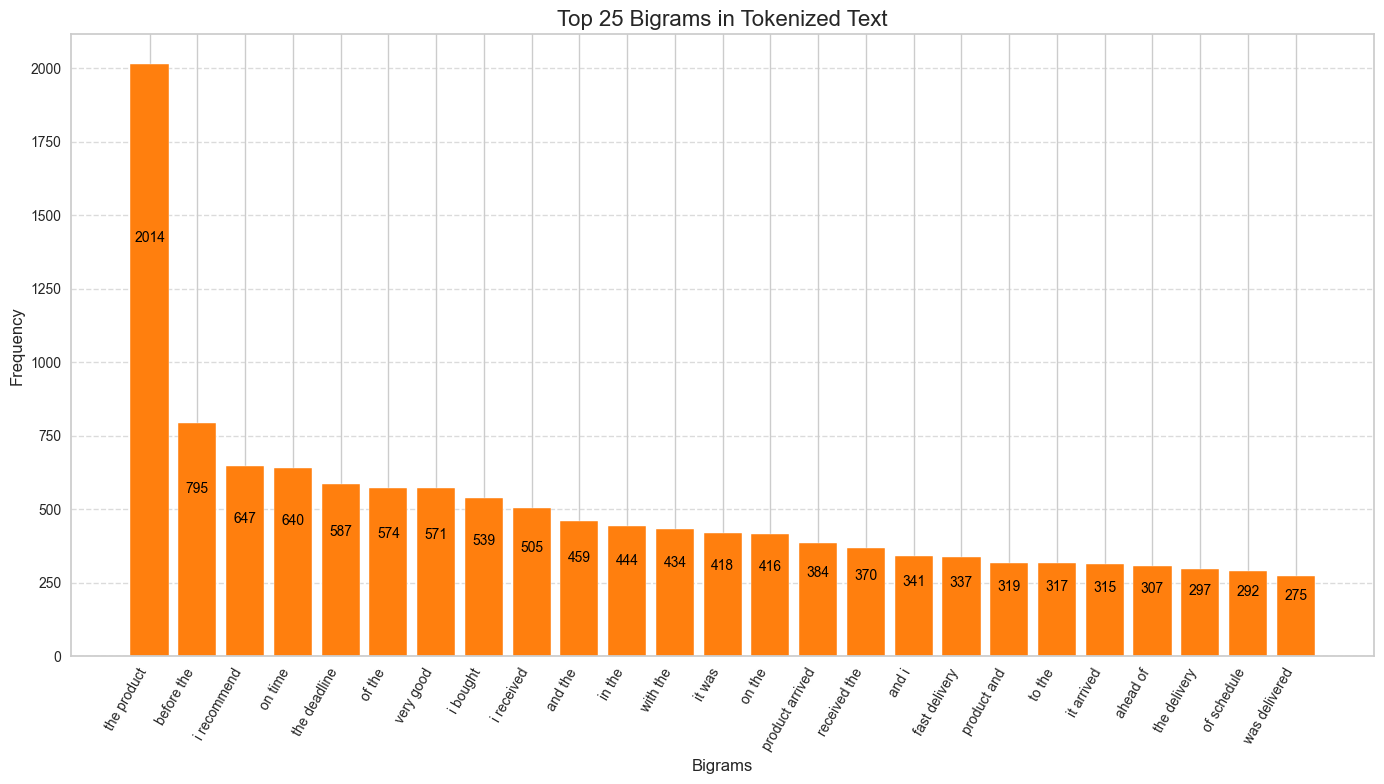

In [ ]:
# N-gram generator and frequency counter
def get_top_ngrams(tokens_list, n=2, top_n=25):
    ngram_counts = Counter(
        ngram for tokens in tokens_list if tokens for ngram in ngrams(tokens, n)
    )
    # Create DataFrame directly from the most common n-grams
    return pd.DataFrame(ngram_counts.most_common(top_n), columns=['Bigram', 'Frequency'])

# Generate top 25 bigrams and plot
top_bigrams_df = get_top_ngrams(nlp_df['review_comment_message_tokens'], n=2, top_n=25)

# Plotting
plt.figure(figsize=(14, 8))
bars = plt.bar(
    [f'{gram[0]} {gram[1]}' for gram in top_bigrams_df['Bigram']],
    top_bigrams_df['Frequency'])

# Add count labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() - max(5, bar.get_height() * 0.3),
             f'{int(bar.get_height())}', ha='center', color='black', fontsize=10)

# Customize the chart
plt.xlabel('Bigrams', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Top 25 Bigrams in Tokenized Text', fontsize=16)
plt.xticks(rotation=60, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Now let's find out how many comments have some value.

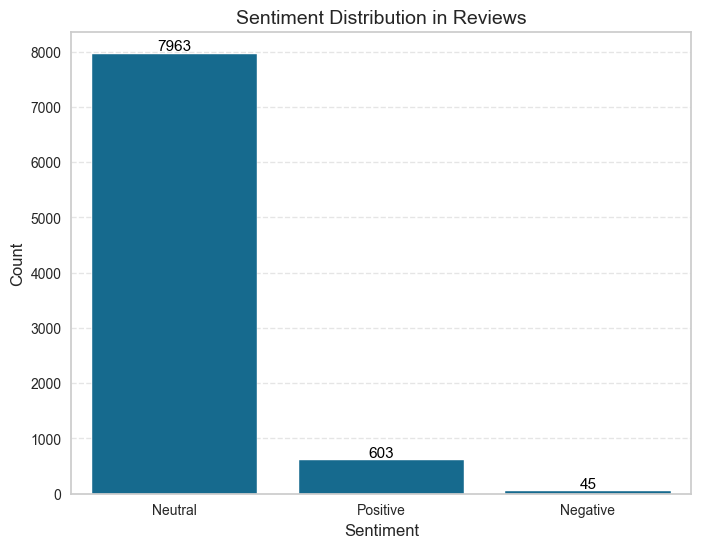

In [ ]:
# Plot the sentiment count
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="review_comment_message_clean_sentiment", data=nlp_df)

# Add labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Distribution in Reviews", fontsize=14)

# Display value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Reduce gridline visibility for a cleaner look
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.5)

plt.show()

We can see how most comments are neutral, this tell us that they dont have much value on them. if we wanted to reccomend products based on the comments it would be very hard as the sample for developing it is quite small.

# End

*Made by Alexander Chong, Oskar Allerbrand & Jorge Esteban Gil, UWE Bristol, 2025:*  